# Julia 1.6.5

In [5]:
using Plots; pyplot()
using Plots.Measures
using DelimitedFiles, DataFrames, CSV, JLD
using StatsBase, Distributions 
using Combinatorics
using ProgressMeter
using RCall
using LaTeXStrings
using LsqFit
using KernelDensity
using SpecialFunctions

# 0. Converting files from rqtl2 to rqtl (if necessary)

In [2]:
dir_data = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data"

cd(dir_data)


In [ ]:
dir_run = "matD/run.pheno_pupalWeight"

df_geno = DataFrame(CSV.File("$(dir_run)/genotypes.csv",header=false))

In [ ]:
df_genmap = DataFrame(CSV.File("$(dir_run)/map.genetic.csv",header=true))

In [182]:
chr_line = string.(vcat([""],df_genmap[!,2]))
map_line = string.(vcat([""],df_genmap[!,3]));

In [183]:
open("$(dir_run)/rqtl.genotypes.csv","w") do f
    
    write(f,join(Array(df_geno[1,:]),","))
    write(f,"\n")
    write(f,join(chr_line,","))
    write(f,"\n")
    write(f,join(map_line,","))
    write(f,"\n")
    
    for i in 2:size(df_geno)[1]
        write(f,join(Array(df_geno[i,:]),","))
        write(f,"\n")
    end
    
end

# 1. Functions to handle QTL results

In [2]:
function plot_1scan_2scan_LOD_with_E(pmap,out2,E)
    
c = cgrad(:island,rev=true)
fig = plot(size=(300,375))

# x = marker_pos_cumulative
# z = out2[:lod]
# heatmap!(fig,x,x,z,
#     xticks=(chr_center,vcat(string.(Array(1:29)),["Z"])),
#     yticks=(chr_center,vcat(string.(Array(1:29)),["Z"])),
#     aspect_ratio=1,
#     guidefontsize=6,
#     color=c,
#     colorbar=:none,
#     clims=(0,maximum(out2[:lod])),
#     format=:png,
#     subplot=1,
# )

x = pmap[Symbol("30")]

z = zeros(size(out2[:lod]))

for i in 1:size(out2[:lod])[1]
    for j in 1:size(out2[:lod])[1]
        z[i,j] = i>j ? NaN : out2[:lod][i,j]
    end
end

x0 = 0:0.05:x[end]
z0 = zeros(length(x0),length(x0))

for i in 1:size(z0)[1]
    for j in 1:size(z0)[1]
        z0[i,j] = i<j ? NaN : 1
    end
end

heatmap!(fig,x,x,z,
    colorbar=false,
    xlabel="Two-locus scan",
    ylabel="Mb",
    guidefontsize=10,
    titlefontsize=10,
    # aspect_ratio=1,
    grid=:off,
    color=c,
    clims=(0,maximum(out2[:lod])),
    format=:png,
    top_margin=1.95cm,
)

heatmap!(fig,x0,x0,z0,
    colorbar=false,
    guidefontsize=10,
    titlefontsize=10,
    grid=:off,
    color=cgrad([:white,:white]),
    format=:png,
)

plot!(fig,[0,x[end]],[0,x[end]],
    label="",
    color=:black,
    linewidth=1,
    linestyle=:dot,
    xlims=(-0.15,x[end]),
    ylims=(0,x[end]),
)

heatmap!(fig,x,x,E ./ maximum(E[.! isnan.(E)]) .* maximum(out2[:lod]),
    framestyle=:box,
    color=cgrad(:RdGy_4,rev=true),
)

annotate!(fig,[(3.75,4.75,Plots.text("Epistasis",8,rotation=45,:black,))])
annotate!(fig,[(4.75,3.75,Plots.text("Pairwise LOD",8,rotation=45,:black,))])

plot!(fig,x,[out2[:lod][i,i] for i in 1:size(out2[:lod])[1]],
    label="",
    inset = (1, bbox(0.0, 1, 1.0, 0.2, :bottom, :left)),
    framestyle=:box,
    xticks=[],
    linecolor=:gray,
    ylims=(0,+Inf),
    xlims=(-0.15,x[end]),
    title="One-locus scan",
    ylabel="LOD",
    yguidefontsize=8,
    titlefontsize=10,
    grid=:off,
    # aspect_ratio=0.2,
    subplot=2,
)

return fig
end

function epistatic_effect(id11,id10,id01,id00,p)
    
    p11 = p[id11]
    p00 = p[id00]
    p10 = p[id10]
    p01 = p[id01]
    
    if any((length.([p11,p00,p10,p01])) .< 2)
        return NaN
    else
        δ = mean(p11)+mean(p00)-mean(p10)-mean(p01)
        var_δ = var(p11)/length(p11)+var(p10)/length(p10)+var(p01)/length(p01)+var(p00)/length(p00)
        std_δ = sqrt(var_δ)
        
        if abs(δ)/std_δ >= 5 
            return abs.(δ)
        else
            return NaN
        end
        
    end

end

function get_epistatic_effect(l1,l2,g,p)
    
    g_sub = g[:,[l1,l2]]
    id11 = (g_sub[:,1] .== 1) .& (g_sub[:,2] .== 1)
    id10 = (g_sub[:,1] .== 1) .& (g_sub[:,2] .== 0)
    id01 = (g_sub[:,1] .== 0) .& (g_sub[:,2] .== 1)
    id00 = (g_sub[:,1] .== 0) .& (g_sub[:,2] .== 0);

    return epistatic_effect(id11,id10,id01,id00,p)   
    
end

get_epistatic_effect (generic function with 1 method)

# 2. QTL analysis: Maternal = B

## 2.1. Empty phenotype, all individuals

In [ ]:
R"""

library("qtl2")

setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matB/run.pheno_empty")

matB <- read_cross2("control.yaml")

gmap = matB$gmap
pmap = matB$pmap
pheno = matB$pheno

pr <- calc_genoprob(matB, gmap, map_function="morgan", error_prob=0.002)

out <- scan1(pr, pheno, model="binary")

operm <- scan1perm(pr, pheno, n_perm=1000)

"""

In [100]:
map = @rget pmap
out = @rget out

R"s_operm <- summary(operm)"

s_operm = @rget s_operm;

In [101]:
markersizes = []
for chr in 1:30
    push!(markersizes,size(map[Symbol("$(chr)")])[1])
end
marker_idx_range = vcat([0],cumsum(markersizes));

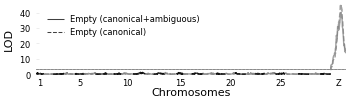

In [107]:
fig = plot(size=(350,100))
colors=[:gray,:black]
for chr in 1:30
    if chr == 1
        pos = map[Symbol("$(chr)")]
    else
        pos = map[Symbol("$(chr)")] .+ sum([map[Symbol("$(i)")][end] for i in 1:(chr-1)])
    end
    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],1],
        label=chr == 1 ? "Empty (canonical+ambiguous)" : "",
        legendfontsize=6,
        legend=:topleft,
        legend_background_color=false,
        linecolor=colors[chr%2+1],
        xticks=[],
        linewidth=1,
        linealpha=0.75,
        ylims=(-0.5,+Inf),
        xlims=(-Inf,+Inf),
        grid=:off,
        ylabel="LOD",
        yguidefontsize=8,
        ytickfontsize=6,
        framestyle=:grid,
        bottom_margin=0.5cm,
        )
    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],2],
        label=chr == 1 ? "Empty (canonical)" : "",
        linecolor=colors[chr%2+1],
        xticks=[],
        linewidth=1,
        linealpha=0.75,
        linestyle=:dash,
        ylims=(-0.5,+Inf),
        grid=:off,
        ylabel="LOD",
        bottom_margin=0.5cm,
        )
    if any(chr .== [1,5,10,15,20,25,30])
        annotate!(fig,[(mean([pos[1],pos[end]]),-6,Plots.text(chr!=30 ? "$(chr)" : "Z",6))])
    end
    if chr == 30
        annotate!(fig,[(pos[end]/2,-12,Plots.text("Chromosomes",8))])
    end
end

hline!(fig,[s_operm[1]],
    linecolor=:gray,
    linewidth=0.5,
    label="",
    linestyle=:solid)
hline!(fig,[s_operm[2]],
    linecolor=:gray,
    linewidth=0.5,
    label="",
    linestyle=:dash)

fig

In [108]:
R"peaks <- find_peaks(out, pmap, threshold=5, prob=0.95)"

RObject{VecSxp}
  lodindex              lodcolumn chr      pos      lod    ci_lo    ci_hi
1        1 Empty_IncludeAmbiguous  30 12.18279 40.12502 11.64904 12.25411
2        2 Empty_ExcludeAmbiguous  30 11.45892 45.56313 11.37611 12.25411


**Note**

lodindex 1: the peak is for the interval $[11.458917,11.536238]$

lodindex 2: the peak is for the interval $[12.182791,12.254113]$

In [109]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalB/run.pheno_empty"

savefig(fig,string("$(dir_output)/lod_score.png"))
savefig(fig,string("$(dir_output)/lod_score.pdf"))

#### Two dimensional scan

In [ ]:
R"""

library("qtl")
setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matB")


matB = read.cross("csvs", "run.pheno_empty", "rqtl.genotypes.csv", "rqtl.phenotypes.csv", alleles=c("B","D"), genotypes=c("DB","BB"))

matB <- calc.genoprob(matB)

out2 <- scantwo(matB,model="binary",pheno.col=c("Empty_ExcludeAmbiguous"), chr=c("30"))
#out2_perm <- scantwo(matD,model="binary",pheno.col=c("Empty_ExcludeAmbiguous"), chr=c("30"), n.perm = 2)


library("qtl2")
matB2 <- read_cross2("run.pheno_empty/control.yaml")

pmap = matB2$pmap
gmap = matB2$gmap
"""

In [5]:
@rget out2
# @rget out2_perm
@rget pmap
@rget gmap;

In [6]:
marker_pos_cumulative = []
chr_center = []
for chr in 1:30
    if chr == 1
        push!(marker_pos_cumulative,pmap[Symbol("$(chr)")])
        push!(chr_center,mean(pmap[Symbol("$(chr)")]))
    else
        push!(marker_pos_cumulative,pmap[Symbol("$(chr)")] .+ sum([pmap[Symbol("$(i)")][end] for i in 1:(chr-1)]))
        push!(chr_center,mean(pmap[Symbol("$(chr)")]) + sum([pmap[Symbol("$(i)")][end] for i in 1:(chr-1)]))
    end
end
marker_pos_cumulative = vcat(marker_pos_cumulative...);

In [7]:
## calculate Epistasis direction ("E")
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data"

dir_sub = "matB/run.pheno_empty"

geno = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/genotypes.csv"))
geno = geno[:,end-163:end]
pheno = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/phenotypes.csv"));

g = Array(geno .== "DB")
p = pheno[!,:Empty_ExcludeAmbiguous];

E = zeros(size(g)[2],size(g)[2]) .+ NaN
for i in 1:size(g)[2]
    for j in (i+1):1:size(g)[2]
        E[j,i] = get_epistatic_effect(i,j,g,p)   
    end
end

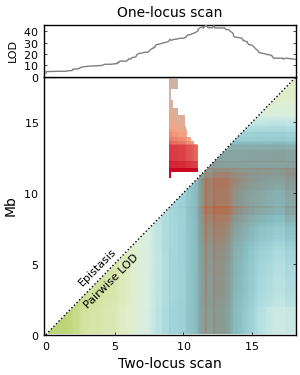

In [8]:
fig = plot_1scan_2scan_LOD_with_E(pmap,out2,E)

In [9]:
R"""
s = summary(out2)
"""
@rget gmap
@rget s

## print two peak positions
pos1f = pmap[Symbol("30")][findfirst(gmap[Symbol("30")] .== s[1,:pos1f])]
pos2f = pmap[Symbol("30")][findfirst(gmap[Symbol("30")] .== s[1,:pos2f])]
pos1a = pmap[Symbol("30")][findfirst(gmap[Symbol("30")] .== s[1,:pos1a])]
pos2a = pmap[Symbol("30")][findfirst(gmap[Symbol("30")] .== s[1,:pos2a])];

types = ["pos1f","pos2f","pos1a","pos2a"]
values = [pos1f,pos2f,pos1a,pos2a]

for i in 1:4
    println(string(types[i],": "),values[i])
end

pos1f: 9.0401
pos2f: 12.254113
pos1a: 9.0401
pos2a: 12.254113


In [10]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalB/run.pheno_empty"

savefig(fig,string("$(dir_output)/2D.Z.lod_score.png"))
savefig(fig,string("$(dir_output)/2D.Z.lod_score.pdf"))

## 2.2. Normal phenotype, on individuals with Z chromosomes being pure P. bianor

In [ ]:
R"""

library("qtl2")

setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matB/run.pheno_normal.Z_pureB")

matB <- read_cross2("control.yaml")

gmap = matB$gmap
pmap = matB$pmap
pheno = matB$pheno

pr <- calc_genoprob(matB, gmap, map_function="morgan", error_prob=0.002)

out <- scan1(pr, pheno, model="binary")

operm <- scan1perm(pr, pheno, n_perm=1000)

"""

In [111]:
map = @rget pmap
out = @rget out

R"s_operm <- summary(operm)"

s_operm = @rget s_operm;

In [112]:
markersizes = []
for chr in 1:29
    push!(markersizes,size(map[Symbol("$(chr)")])[1])
end
marker_idx_range = vcat([0],cumsum(markersizes));

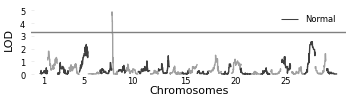

In [125]:
fig = plot(size=(350,100))
colors=[:gray,:black]
for chr in 1:29
    if chr == 1
        pos = map[Symbol("$(chr)")]
    else
        pos = map[Symbol("$(chr)")] .+ sum([map[Symbol("$(i)")][end] for i in 1:(chr-1)])
    end

    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],2],
        label=chr==1 ? "Normal" : "",
        legend=:topright,
        legend_background_color=false,
        linecolor=colors[chr%2+1],
        xticks=[],
        linewidth=1,
        linealpha=0.75,
        ylims=(-0.05,5.5),
        grid=:off,
        ylabel="LOD",
        yguidefontsize=8,
        ytickfontsize=6,
        legendfontsize=6,
        framestyle=:grid,
        bottom_margin=0.5cm,
        )
    if any(chr .== [1,5,10,15,20,25,30])
        annotate!(fig,[(mean([pos[1],pos[end]]),-0.6,Plots.text(chr!=30 ? "$(chr)" : "Z",6))])
    end
    if chr == 29
        annotate!(fig,[(pos[end]/2,-1.3,Plots.text("Chromosomes",8))])
    end
end

hline!(fig,[s_operm[2]],
    linecolor=:gray,
    linewidth=1,
    label="",
    linestyle=:solid)

fig

In [122]:
R"peaks <- find_peaks(out, pmap, threshold=4, prob=0.95)"

RObject{VecSxp}
  lodindex               lodcolumn chr      pos      lod    ci_lo    ci_hi
1        2 Normal_ExcludeAmbiguous   8 0.366353 4.875207 0.005916 0.784124


In [126]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalB/run.pheno_normal.Z_pureB"

savefig(fig,string("$(dir_output)/lod_score.png"))
savefig(fig,string("$(dir_output)/lod_score.pdf"))

## 2.3. Normal phenotype, on individuals with Z chromosomes being pure bianor and chr8 leftend being pure dehaanii

In [ ]:
R"""

library("qtl2")

setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matB/run.pheno_normal.Z_pureB.chr8_leftEndPureD")

matB <- read_cross2("control.yaml")

gmap = matB$gmap
pmap = matB$pmap
pheno = matB$pheno

pr <- calc_genoprob(matB, gmap, map_function="morgan", error_prob=0.002)

out <- scan1(pr, pheno, model="binary", tol=0.0001)

operm <- scan1perm(pr, pheno, n_perm=1000)

"""

In [162]:
map = @rget pmap
out = @rget out

R"s_operm <- summary(operm)"

s_operm = @rget s_operm;

In [163]:
markersizes = []
for chr in 1:29
    push!(markersizes,size(map[Symbol("$(chr)")])[1])
end
marker_idx_range = vcat([0],cumsum(markersizes));

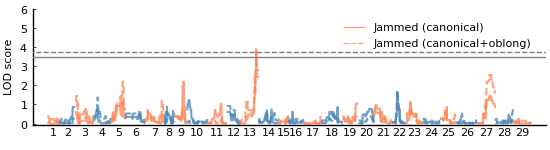

In [168]:
fig = plot(size=(550,150))
colors=[:steelblue,:coral]
for chr in 1:29
    if chr == 1
        pos = map[Symbol("$(chr)")]
    else
        pos = map[Symbol("$(chr)")] .+ sum([map[Symbol("$(i)")][end] for i in 1:(chr-1)])
    end
    
    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],1],
        label=chr==1 ? "Jammed (canonical)" : "",
        linecolor=colors[chr%2+1],
        xticks=[],
        linewidth=1.5,
        linealpha=0.75,
        ylims=(-0.05,5),
        grid=:off,
        ylabel="LOD score",
        yguidefontsize=10,
        bottom_margin=0.5cm,
        )

    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],2],
        label=chr==1 ? "Jammed (canonical+oblong)" : "",
        legend=:topright,
        legend_column=2,
        legend_background_color=false,
        linecolor=colors[chr%2+1],
        linestyle=:dash,
        xticks=[],
        linewidth=1.5,
        linealpha=0.75,
        ylims=(-0.05,6),
        grid=:off,
        ylabel="LOD score",
        yguidefontsize=8,
        bottom_margin=0.5cm,
        )
    annotate!(fig,[(mean([pos[1],pos[end]]),-0.5,Plots.text(chr!=30 ? "$(chr)" : "Z",8))])
end

hline!(fig,[s_operm[1]],
    linecolor=:gray,
    linewidth=1,
    label="",
    linestyle=:solid)
hline!(fig,[s_operm[2]],
    linecolor=:gray,
    linewidth=1,
    label="",
    linestyle=:dash)

fig

In [137]:
R"peaks <- find_peaks(out, pmap, threshold=3.5, prob=0.95)"

RObject{VecSxp}
  lodindex             lodcolumn chr      pos      lod   ci_lo    ci_hi
1        1 Jammed_PerfectlyRound  13 11.61979 3.898554 11.0396 13.65245
2        2   Jammed_Round+Oblong  13 11.61979 3.755264 10.6861 13.65245


In [169]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalB/run.pheno_normal.Z_pureB.chr8_leftEndPureD"

savefig(fig,string("$(dir_output)/lod_score.png"))
savefig(fig,string("$(dir_output)/lod_score.pdf"))

## 2.4. Normal phenotype, on individuals with Z chromosomes lacking the Empty allele

In [ ]:
R"""

library("qtl2")

setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matB/run.pheno_normal.Z_noEmptyFactor")

matB <- read_cross2("control.yaml")

gmap = matB$gmap
pmap = matB$pmap
pheno = matB$pheno

pr <- calc_genoprob(matB, gmap, map_function="morgan", error_prob=0.002)

out <- scan1(pr, pheno, model="binary", tol=0.000001)

operm <- scan1perm(pr, pheno, n_perm=1000)

"""

In [70]:
map = @rget pmap
out = @rget out

R"s_operm <- summary(operm)"

s_operm = @rget s_operm;

In [71]:
markersizes = []
for chr in 1:30
    push!(markersizes,size(map[Symbol("$(chr)")])[1])
end
marker_idx_range = vcat([0],cumsum(markersizes));

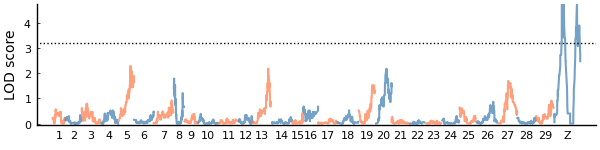

In [72]:
fig = plot(size=(600,150))
colors=[:steelblue,:coral]
for chr in 1:30
    if chr == 1
        pos = map[Symbol("$(chr)")]
    else
        pos = map[Symbol("$(chr)")] .+ sum([map[Symbol("$(i)")][end] for i in 1:(chr-1)])
    end

    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],2],
        label="",
        legend=:topleft,
        linecolor=colors[chr%2+1],
        xticks=[],
        linewidth=1.5,
        linealpha=0.75,
        ylims=(-0.05,+Inf),
        grid=:off,
        ylabel="LOD score",
        yguidefontsize=10,
        bottom_margin=0.5cm,
        )
    annotate!(fig,[(mean([pos[1],pos[end]]),-0.5,Plots.text(chr!=30 ? "$(chr)" : "Z",8))])
end

hline!(fig,[s_operm[2]],
    linecolor=:black,
    label="",
    linestyle=:dot)

fig

## 2.5. Pupal weights, using broods as individual covariates
broods = individuals reared at the same time of the year

In [ ]:
R"""

library("qtl2")

setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matB/run.pheno_pupalWeight_BBD")

matB <- read_cross2("control.yaml")

pmap = matB$pmap
gmap = matB$gmap
pheno = matB$pheno

pr <- calc_genoprob(matB, gmap, error_prob=0.002)

covar <- match(matB$covar$Brood, c("I", "II","III","IV"))
names(covar) <- rownames(matB$covar)

out <- scan1(pr, pheno, addcovar=covar)

operm <- scan1perm(pr, matB$pheno, n_perm=1000)

"""

In [131]:
map = @rget pmap
out = @rget out

R"s_operm <- summary(operm)"

s_operm = @rget s_operm;

In [132]:
markersizes = []
for chr in 1:30
    push!(markersizes,size(map[Symbol("$(chr)")])[1])
end
marker_idx_range = vcat([0],cumsum(markersizes));

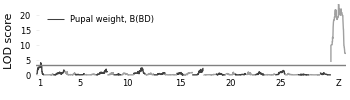

In [134]:
fig = plot(size=(350,100))
colors=[:gray,:black]
for chr in 1:30
    if chr == 1
        pos = map[Symbol("$(chr)")]
    else
        pos = map[Symbol("$(chr)")] .+ sum([map[Symbol("$(i)")][end] for i in 1:(chr-1)])
    end

    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],1],
        label=chr==1 ? "Pupal weight, B(BD)" : "",
        legendfontsize=6,
        legend=:topleft,
        legend_background_color=false,
        linecolor=colors[chr%2+1],
        xticks=[],
        linewidth=1,
        linealpha=0.75,
        ylims=(-1,+Inf),
        xlims=(-Inf,+Inf),
        grid=:off,
        ylabel="LOD score",
        yguidefontsize=8,
        ytickfontsize=6,
        framestyle=:grid,
        bottom_margin=0.5cm,
        )
    if any(chr .== [1,5,10,15,20,25,30])
        annotate!(fig,[(mean([pos[1],pos[end]]),-3,Plots.text(chr!=30 ? "$(chr)" : "Z",6))])
    end
end

hline!(fig,[s_operm[1]],
    linecolor=:gray,
    linewidth=1,
    label="",
    linestyle=:solid)

fig

In [135]:
R"peaks <- find_peaks(out, pmap, threshold=3.5, prob=0.95)"

RObject{VecSxp}
  lodindex    lodcolumn chr      pos       lod    ci_lo     ci_hi
1        1 Pupal_Weight   1 5.162224  4.016472 2.310178  6.515355
2        1 Pupal_Weight  30 9.124007 23.609275 9.124007 12.254113


In [136]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalB/run.pheno_pupalWeight"

savefig(fig,string("$(dir_output)/lod_score_BBD.png"))
savefig(fig,string("$(dir_output)/lod_score_BBD.pdf"))

#### two dimensional scan

In [ ]:
R"""

library("qtl")
setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matB")


matB = read.cross("csvs", "run.pheno_pupalWeight_BBD", "rqtl.genotypes.csv", "rqtl.phenotypes.csv", alleles=c("B","D"), genotypes=c("DB","BB"))

matB <- calc.genoprob(matB)

out2 <- scantwo(matB,model="normal",method="em",pheno.col=c("Pupal_Weight"), chr=c("30"))
#out2_perm <- scantwo(matB,model="normal",method="em",pheno.col=c("Pupal_Weight"), chr=c("30"), n.perm = 2)


library("qtl2")
matB2 <- read_cross2("run.pheno_pupalWeight_BBD/control.yaml")

pmap = matB2$pmap
gmap = matB2$gmap

"""

In [40]:
@rget out2
#@rget out2_perm
@rget pmap
@rget gmap;

In [13]:
marker_pos_cumulative = []
chr_center = []
for chr in 1:30
    if chr == 1
        push!(marker_pos_cumulative,pmap[Symbol("$(chr)")])
        push!(chr_center,mean(pmap[Symbol("$(chr)")]))
    else
        push!(marker_pos_cumulative,pmap[Symbol("$(chr)")] .+ sum([pmap[Symbol("$(i)")][end] for i in 1:(chr-1)]))
        push!(chr_center,mean(pmap[Symbol("$(chr)")]) + sum([pmap[Symbol("$(i)")][end] for i in 1:(chr-1)]))
    end
end
marker_pos_cumulative = vcat(marker_pos_cumulative...);

In [14]:
## calculate Epistasis direction ("E")
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data"

dir_sub = "matB/run.pheno_pupalWeight"

geno = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/genotypes.csv"))
geno = geno[:,end-163:end]
pheno = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/phenotypes.csv"));

g = Array(geno .== "DB")
p = pheno[!,:Pupal_Weight];

E = zeros(size(g)[2],size(g)[2]) .+ NaN
for i in 1:size(g)[2]
    for j in (i+1):1:size(g)[2]
        E[j,i] = get_epistatic_effect(i,j,g,p)   
    end
end

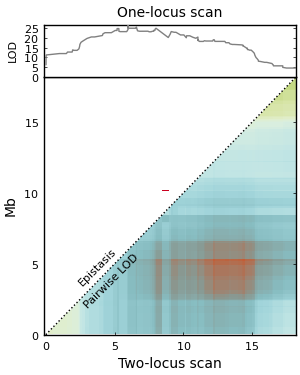

In [15]:
fig = plot_1scan_2scan_LOD_with_E(pmap,out2,E)

In [16]:
R"""
gmap = matB2$gmap
s = summary(out2)
"""
@rget gmap
@rget s

## print two peak positions
pos1f = pmap[Symbol("30")][findfirst(gmap[Symbol("30")] .== s[1,:pos1f])]
pos2f = pmap[Symbol("30")][findfirst(gmap[Symbol("30")] .== s[1,:pos2f])]
pos1a = pmap[Symbol("30")][findfirst(gmap[Symbol("30")] .== s[1,:pos1a])]
pos2a = pmap[Symbol("30")][findfirst(gmap[Symbol("30")] .== s[1,:pos2a])];

types = ["pos1f","pos2f","pos1a","pos2a"]
values = [pos1f,pos2f,pos1a,pos2a]

for i in 1:4
    println(string(types[i],": "),values[i])
end

pos1f: 5.211479
pos2f: 14.337736
pos1a: 5.211479
pos2a: 14.337736


In [17]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalB/run.pheno_pupalWeight"

savefig(fig,string("$(dir_output)/2D.Z.lod_score.png"))
savefig(fig,string("$(dir_output)/2D.Z.lod_score.pdf"))

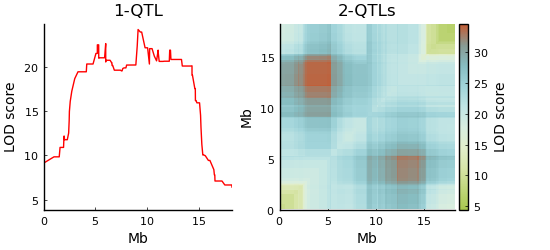

In [41]:
## Alternative figures for LOD scores

lod1scan = [out2[:lod][i,i] for i in 1:size(out2[:lod])[1]]

fig = plot(size=(550,250),layout=(1,2))

plot!(fig,pmap[Symbol("30")],lod1scan,
    grid=:off,
    ylabel="LOD score",
    xlabel="Mb",
    yguidefontsize=10,
    xguidefontsize=10,
    xlims=(0,+Inf),
    label="",
    linecolor=:red,
    title="1-QTL",
    titlefontsize=12,
    subplot=1)

heatmap!(fig,pmap[Symbol("30")],pmap[Symbol("30")],out2[:lod],
    grid=:off,
    ylabel="Mb",
    xlabel="Mb",
    yguidefontsize=10,
    xguidefontsize=10,
    xlims=(0,+Inf),
    ylims=(0,+Inf),
    label="",
    title="2-QTLs",
    titlefontsize=12,
    color=cgrad(:island,rev=true),
    colorbar_title="LOD score",
    subplot=2,)

In [42]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalB/run.pheno_pupalWeight"

savefig(fig,string("$(dir_output)/1D2D.Z.lod_score.png"))
savefig(fig,string("$(dir_output)/1D2D.Z.lod_score.pdf"))

# 3. QTL analysis: Maternal = D

## 3.1. Pupal weights, using broods as individual covariates
broods = individuals reared at the same time of the year

In [ ]:
R"""

library("qtl2")

setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matD/run.pheno_pupalWeight")

matD <- read_cross2("control.yaml")

pmap = matD$pmap
gmap = matD$gmap
pheno = matD$pheno

pr <- calc_genoprob(matD, gmap, error_prob=0.002)

covar <- match(matD$covar$Brood, c("I", "II","III","IV"))
names(covar) <- rownames(matD$covar)

out <- scan1(pr, pheno, addcovar=covar)

operm <- scan1perm(pr, matD$pheno, n_perm=1000)

"""

In [138]:
map = @rget pmap
out = @rget out

R"s_operm <- summary(operm)"

s_operm = @rget s_operm;

In [139]:
markersizes = []
for chr in 1:30
    push!(markersizes,size(map[Symbol("$(chr)")])[1])
end
marker_idx_range = vcat([0],cumsum(markersizes));

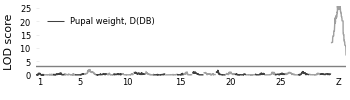

In [141]:
fig = plot(size=(350,100))
colors=[:gray,:black]
for chr in 1:30
    if chr == 1
        pos = map[Symbol("$(chr)")]
    else
        pos = map[Symbol("$(chr)")] .+ sum([map[Symbol("$(i)")][end] for i in 1:(chr-1)])
    end

    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],1],
        label=chr==1 ? "Pupal weight, D(DB)" : "",
        legendfontsize=6,
        legend=:topleft,
        legend_background_color=false,
        linecolor=colors[chr%2+1],
        xticks=[],
        linewidth=1,
        linealpha=0.75,
        ylims=(-1,+Inf),
        xlims=(-Inf,+Inf),
        grid=:off,
        ylabel="LOD score",
        yguidefontsize=8,
        ytickfontsize=6,
        framestyle=:grid,
        bottom_margin=0.5cm,
        )
    if any(chr .== [1,5,10,15,20,25,30])
        annotate!(fig,[(mean([pos[1],pos[end]]),-3,Plots.text(chr!=30 ? "$(chr)" : "Z",6))])
    end
end

hline!(fig,[s_operm[1]],
    linecolor=:gray,
    linewidth=1,
    label="",
    linestyle=:solid)

fig

In [142]:
R"peaks <- find_peaks(out, pmap, threshold=3.5, prob=0.95)"

RObject{VecSxp}
  lodindex    lodcolumn chr      pos      lod    ci_lo    ci_hi
1        1 Pupal_Weight  30 11.06879 25.73235 7.855832 11.37611


In [143]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_pupalWeight"

savefig(fig,string("$(dir_output)/lod_score_DDB.png"))
savefig(fig,string("$(dir_output)/lod_score_DDB.pdf"))

##### Two dimensional scan

In [ ]:
R"""

library("qtl")
setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matD")


matD = read.cross("csvs", "run.pheno_pupalWeight", "rqtl.genotypes.csv", "rqtl.phenotypes.csv", alleles=c("B","D"), genotypes=c("DB","DD"))

matD <- calc.genoprob(matD)

out2 <- scantwo(matD,model="normal",method="em",pheno.col=c("Pupal_Weight"), chr=c("30"))
#out2_perm <- scantwo(matD,model="normal",method="em",pheno.col=c("Pupal_Weight"), chr=c("30"), n.perm = 2)


library("qtl2")
matD2 <- read_cross2("run.pheno_pupalWeight/control.yaml")

pmap = matD2$pmap
gmap = matD2$gmap
"""

In [7]:
@rget out2
#@rget out2_perm
@rget pmap
@rget gmap;

In [8]:
marker_pos_cumulative = []
chr_center = []
for chr in 1:30
    if chr == 1
        push!(marker_pos_cumulative,pmap[Symbol("$(chr)")])
        push!(chr_center,mean(pmap[Symbol("$(chr)")]))
    else
        push!(marker_pos_cumulative,pmap[Symbol("$(chr)")] .+ sum([pmap[Symbol("$(i)")][end] for i in 1:(chr-1)]))
        push!(chr_center,mean(pmap[Symbol("$(chr)")]) + sum([pmap[Symbol("$(i)")][end] for i in 1:(chr-1)]))
    end
end
marker_pos_cumulative = vcat(marker_pos_cumulative...);

In [21]:
## calculate Epistasis direction ("E")
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data"

dir_sub = "matD/run.pheno_pupalWeight"

geno = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/genotypes.csv"))
geno = geno[:,end-163:end]
pheno = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/phenotypes.csv"));

g = Array(geno .== "DB")
p = pheno[!,:Pupal_Weight];

E = zeros(size(g)[2],size(g)[2]) .+ NaN
for i in 1:size(g)[2]
    for j in (i+1):1:size(g)[2]
        E[j,i] = get_epistatic_effect(i,j,g,p)   
    end
end

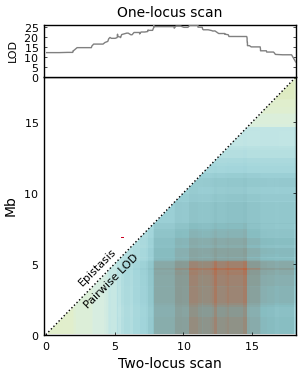

In [25]:
fig = plot_1scan_2scan_LOD_with_E(pmap,out2,E)

In [23]:
R"""
gmap = matB2$gmap
s = summary(out2)
"""
@rget gmap
@rget s

## print two peak positions
pos1f = pmap[Symbol("30")][findfirst(gmap[Symbol("30")] .== s[1,:pos1f])]
pos2f = pmap[Symbol("30")][findfirst(gmap[Symbol("30")] .== s[1,:pos2f])]
pos1a = pmap[Symbol("30")][findfirst(gmap[Symbol("30")] .== s[1,:pos1a])]
pos2a = pmap[Symbol("30")][findfirst(gmap[Symbol("30")] .== s[1,:pos2a])];

types = ["pos1f","pos2f","pos1a","pos2a"]
values = [pos1f,pos2f,pos1a,pos2a]

for i in 1:4
    println(string(types[i],": "),values[i])
end

pos1f: 4.669949
pos2f: 14.61026
pos1a: 4.669949
pos2a: 14.61026


In [26]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_pupalWeight"

savefig(fig,string("$(dir_output)/2D.Z.lod_score.png"))
savefig(fig,string("$(dir_output)/2D.Z.lod_score.pdf"))

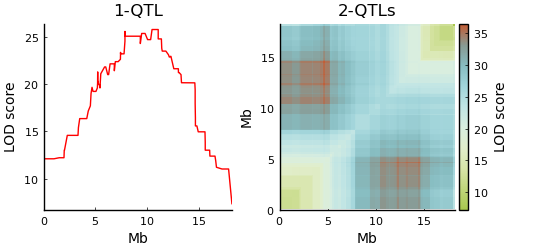

In [36]:
## Alternative figures for LOD scores

lod1scan = [out2[:lod][i,i] for i in 1:size(out2[:lod])[1]]

fig = plot(size=(550,250),layout=(1,2))

plot!(fig,pmap[Symbol("30")],lod1scan,
    grid=:off,
    ylabel="LOD score",
    xlabel="Mb",
    yguidefontsize=10,
    xguidefontsize=10,
    xlims=(0,+Inf),
    label="",
    linecolor=:red,
    title="1-QTL",
    titlefontsize=12,
    subplot=1)

heatmap!(fig,pmap[Symbol("30")],pmap[Symbol("30")],out2[:lod],
    grid=:off,
    ylabel="Mb",
    xlabel="Mb",
    yguidefontsize=10,
    xguidefontsize=10,
    xlims=(0,+Inf),
    ylims=(0,+Inf),
    label="",
    title="2-QTLs",
    titlefontsize=12,
    color=cgrad(:island,rev=true),
    colorbar_title="LOD score",
    subplot=2,)

In [37]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_pupalWeight"

savefig(fig,string("$(dir_output)/1D2D.Z.lod_score.png"))
savefig(fig,string("$(dir_output)/1D2D.Z.lod_score.pdf"))

## 3.2. All ovaries in maternally D individuals

In [ ]:
R"""

library("qtl2")

setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matD/run.pheno_allOvaryPhenotypes")

matD <- read_cross2("control.yaml")

pmap = matD$pmap
gmap = matD$gmap
pheno = matD$pheno

pr <- calc_genoprob(matD, gmap, error_prob=0.002)

out <- scan1(pr, pheno, model="binary")

operm <- scan1perm(pr, matD$pheno, n_perm=1000)

"""

In [4]:
map = @rget pmap
out = @rget out

R"s_operm <- summary(operm)"

s_operm = @rget s_operm;

In [5]:
markersizes = []
for chr in 1:30
    push!(markersizes,size(map[Symbol("$(chr)")])[1])
end
marker_idx_range = vcat([0],cumsum(markersizes));

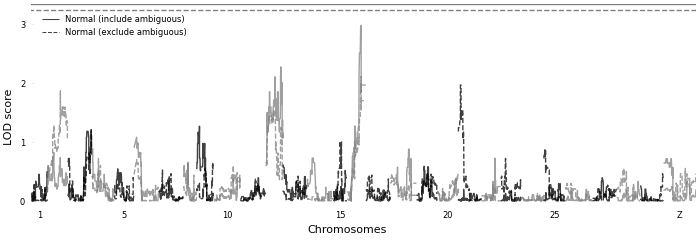

In [21]:
fig = plot(size=(700,250))
colors=[:gray,:black]
for chr in 1:30
    if chr == 1
        pos = map[Symbol("$(chr)")]
    else
        pos = map[Symbol("$(chr)")] .+ sum([map[Symbol("$(i)")][end] for i in 1:(chr-1)])
    end

    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],3],
        label=chr==1 ? "Normal (include ambiguous)" : "",
        legendfontsize=6,
        legend=:topleft,
        legend_background_color=false,
        linecolor=colors[chr%2+1],
        xticks=[],
        linewidth=1,
        linealpha=0.75,
        ylims=(0,1.5),
        xlims=(-Inf,+Inf),
        grid=:off,
        ylabel="LOD",
        # xlabel="Chromosomes",
        xguidefontsize=8,
        yguidefontsize=8,
        ytickfontsize=6,
        # framestyle=:axes,
        bottom_margin=0.5cm,
        )
    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],4],
        label=chr==1 ? "Normal (exclude ambiguous)" : "",
        legendfontsize=6,
        legend=:topleft,
        legend_background_color=false,
        linecolor=colors[chr%2+1],
        linestyle=:dash,
        xticks=[],
        linewidth=1,
        linealpha=0.75,
        ylims=(-0.5,+Inf),
        xlims=(-Inf,+Inf),
        grid=:off,
        ylabel="LOD score",
        yguidefontsize=8,
        ytickfontsize=6,
        framestyle=:grid,
        bottom_margin=0.5cm,
        )
    if any(chr .== [1,5,10,15,20,25,30])
        annotate!(fig,[(mean([pos[1],pos[end]]),-0.25,Plots.text(chr!=30 ? "$(chr)" : "Z",6))])
    end
    if chr == 29
        annotate!(fig,[(pos[end]/2,-0.5,Plots.text("Chromosomes",8))])
    end
end

hline!(fig,[s_operm[3]],
    linecolor=:gray,
    linewidth=1,
    label="",
    linestyle=:solid)

hline!(fig,[s_operm[4]],
    linecolor=:gray,
    linewidth=1,
    label="",
    linestyle=:dash)

fig

In [22]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_allOvaryPhenotypes"

savefig(fig,string("$(dir_output)/lod_score_Normal.png"))
savefig(fig,string("$(dir_output)/lod_score_Normal.pdf"))

## 3.3. Diminished ovaries in individuals with Z chromosome coming from D


In [ ]:
R"""

library("qtl2")

setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matD/run.pheno_diminished_Z_pureD")

matD <- read_cross2("control.yaml")

pmap = matD$pmap
gmap = matD$gmap
pheno = matD$pheno

pr <- calc_genoprob(matD, gmap, error_prob=0.002)

out <- scan1(pr, pheno, model="binary")

operm <- scan1perm(pr, matD$pheno, n_perm=1000)

"""

In [3]:
map = @rget pmap
out = @rget out

R"s_operm <- summary(operm)"

s_operm = @rget s_operm;

In [4]:
markersizes = []
for chr in 1:29
    push!(markersizes,size(map[Symbol("$(chr)")])[1])
end
marker_idx_range = vcat([0],cumsum(markersizes));

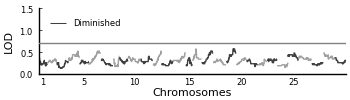

In [33]:
fig = plot(size=(350,100))
colors=[:gray,:black]
for chr in 1:29
    if chr == 1
        pos = map[Symbol("$(chr)")]
    else
        pos = map[Symbol("$(chr)")] .+ sum([map[Symbol("$(i)")][end] for i in 1:(chr-1)])
    end

    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],1],
        label=chr==1 ? "Diminished" : "",
        legendfontsize=6,
        legend=:topleft,
        legend_background_color=false,
        linecolor=colors[chr%2+1],
        xticks=[],
        linewidth=1,
        linealpha=0.75,
        ylims=(0,1.5),
        xlims=(-Inf,+Inf),
        grid=:off,
        ylabel="LOD",
        # xlabel="Chromosomes",
        xguidefontsize=8,
        yguidefontsize=8,
        ytickfontsize=6,
        # framestyle=:axes,
        bottom_margin=0.5cm,
        )
    # plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],2],
    #     label=chr==1 ? "Diminished (canonical)" : "",
    #     legendfontsize=6,
    #     legend=:topleft,
    #     legend_background_color=false,
    #     linecolor=colors[chr%2+1],
    #     linestyle=:dash,
    #     xticks=[],
    #     linewidth=1,
    #     linealpha=0.75,
    #     ylims=(-1,+Inf),
    #     xlims=(-Inf,+Inf),
    #     grid=:off,
    #     ylabel="LOD score",
    #     yguidefontsize=8,
    #     ytickfontsize=6,
    #     framestyle=:grid,
    #     bottom_margin=0.5cm,
    #     )
    if any(chr .== [1,5,10,15,20,25,30])
        annotate!(fig,[(mean([pos[1],pos[end]]),-0.2,Plots.text(chr!=30 ? "$(chr)" : "Z",6))])
    end
    if chr == 29
        annotate!(fig,[(pos[end]/2,-0.45,Plots.text("Chromosomes",8))])
    end
end

hline!(fig,[s_operm[1]],
    linecolor=:gray,
    linewidth=1,
    label="",
    linestyle=:solid)

# hline!(fig,[s_operm[2]],
#     linecolor=:gray,
#     linewidth=1,
#     label="",
#     linestyle=:dash)

fig

In [18]:
R"peaks <- find_peaks(out, pmap, threshold=3.5, prob=0.95)"

RObject{VecSxp}
[1] lodindex  lodcolumn chr       pos       lod       ci_lo     ci_hi    
<0 rows> (or 0-length row.names)


In [34]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_diminished_Z_pureD"

savefig(fig,string("$(dir_output)/lod_score.png"))
savefig(fig,string("$(dir_output)/lod_score.pdf"))

## 3.4. Abnormal ovaries in individuals with Z chromosome coming from B

In [ ]:
R"""

library("qtl2")

setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matD/run.pheno_dysgenesis_Z_pureB")

matD <- read_cross2("control.yaml")

pmap = matD$pmap
gmap = matD$gmap
pheno = matD$pheno

pr <- calc_genoprob(matD, gmap, error_prob=0.002)

out <- scan1(pr, pheno, model="binary")

operm <- scan1perm(pr, matD$pheno, n_perm=1000)

"""

In [45]:
map = @rget pmap
out = @rget out

R"s_operm <- summary(operm)"

s_operm = @rget s_operm;

In [46]:
markersizes = []
for chr in 1:29
    push!(markersizes,size(map[Symbol("$(chr)")])[1])
end
marker_idx_range = vcat([0],cumsum(markersizes));

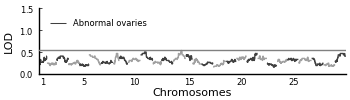

In [50]:
fig = plot(size=(350,100))
colors=[:gray,:black]
for chr in 1:29
    if chr == 1
        pos = map[Symbol("$(chr)")]
    else
        pos = map[Symbol("$(chr)")] .+ sum([map[Symbol("$(i)")][end] for i in 1:(chr-1)])
    end

    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],1],
        label=chr==1 ? "Abnormal ovaries" : "",
        legendfontsize=6,
        legend=:topleft,
        legend_background_color=false,
        linecolor=colors[chr%2+1],
        xticks=[],
        linewidth=1,
        linealpha=0.75,
        ylims=(0,1.5),
        xlims=(-Inf,+Inf),
        grid=:off,
        ylabel="LOD",
        # xlabel="Chromosomes",
        xguidefontsize=8,
        yguidefontsize=8,
        ytickfontsize=6,
        # framestyle=:axes,
        bottom_margin=0.5cm,
        )
    # plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],2],
    #     label=chr==1 ? "Diminished (canonical)" : "",
    #     legendfontsize=6,
    #     legend=:topleft,
    #     legend_background_color=false,
    #     linecolor=colors[chr%2+1],
    #     linestyle=:dash,
    #     xticks=[],
    #     linewidth=1,
    #     linealpha=0.75,
    #     ylims=(-1,+Inf),
    #     xlims=(-Inf,+Inf),
    #     grid=:off,
    #     ylabel="LOD score",
    #     yguidefontsize=8,
    #     ytickfontsize=6,
    #     framestyle=:grid,
    #     bottom_margin=0.5cm,
    #     )
    if any(chr .== [1,5,10,15,20,25,30])
        annotate!(fig,[(mean([pos[1],pos[end]]),-0.2,Plots.text(chr!=30 ? "$(chr)" : "Z",6))])
    end
    if chr == 29
        annotate!(fig,[(pos[end]/2,-0.45,Plots.text("Chromosomes",8))])
    end
end

hline!(fig,[s_operm[1]],
    linecolor=:gray,
    linewidth=1,
    label="",
    linestyle=:solid)

# hline!(fig,[s_operm[2]],
#     linecolor=:gray,
#     linewidth=1,
#     label="",
#     linestyle=:dash)

fig

In [51]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_dysgenesis_Z_pureB"

savefig(fig,string("$(dir_output)/lod_score.png"))
savefig(fig,string("$(dir_output)/lod_score.pdf"))

## 3.5. Jammed ovaries (Canonical+Ambiguous) in individuals with Z chromosome coming from B

In [ ]:
R"""

library("qtl2")

setwd("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matD/run.pheno_jammedIncludeAmbiguous_Z_pureB")

matD <- read_cross2("control.yaml")

pmap = matD$pmap
gmap = matD$gmap
pheno = matD$pheno

pr <- calc_genoprob(matD, gmap, error_prob=0.002)

out <- scan1(pr, pheno, model="binary")

operm <- scan1perm(pr, matD$pheno, n_perm=1000)

"""

In [41]:
map = @rget pmap
out = @rget out

R"s_operm <- summary(operm)"

s_operm = @rget s_operm;

In [42]:
markersizes = []
for chr in 1:29
    push!(markersizes,size(map[Symbol("$(chr)")])[1])
end
marker_idx_range = vcat([0],cumsum(markersizes));

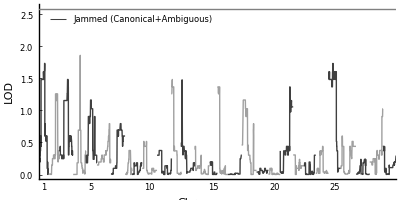

In [43]:
fig = plot(size=(400,200))
colors=[:gray,:black]
for chr in 1:29
    if chr == 1
        pos = map[Symbol("$(chr)")]
    else
        pos = map[Symbol("$(chr)")] .+ sum([map[Symbol("$(i)")][end] for i in 1:(chr-1)])
    end

    plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],1],
        label=chr==1 ? "Jammed (Canonical+Ambiguous)" : "",
        legendfontsize=6,
        legend=:topleft,
        legend_background_color=false,
        linecolor=colors[chr%2+1],
        xticks=[],
        linewidth=1,
        linealpha=0.75,
        # ylims=(0,1.5),
        xlims=(-Inf,+Inf),
        grid=:off,
        ylabel="LOD",
        # xlabel="Chromosomes",
        xguidefontsize=8,
        yguidefontsize=8,
        ytickfontsize=6,
        # framestyle=:axes,
        bottom_margin=0.5cm,
        )
    # plot!(fig,pos,out[marker_idx_range[chr]+1:marker_idx_range[chr+1],2],
    #     label=chr==1 ? "Diminished (canonical)" : "",
    #     legendfontsize=6,
    #     legend=:topleft,
    #     legend_background_color=false,
    #     linecolor=colors[chr%2+1],
    #     linestyle=:dash,
    #     xticks=[],
    #     linewidth=1,
    #     linealpha=0.75,
    #     ylims=(-1,+Inf),
    #     xlims=(-Inf,+Inf),
    #     grid=:off,
    #     ylabel="LOD score",
    #     yguidefontsize=8,
    #     ytickfontsize=6,
    #     framestyle=:grid,
    #     bottom_margin=0.5cm,
    #     )
    if any(chr .== [1,5,10,15,20,25,30])
        annotate!(fig,[(mean([pos[1],pos[end]]),-0.2,Plots.text(chr!=30 ? "$(chr)" : "Z",6))])
    end
    if chr == 29
        annotate!(fig,[(pos[end]/2,-0.45,Plots.text("Chromosomes",8))])
    end
end

hline!(fig,[s_operm[1]],
    linecolor=:gray,
    linewidth=1,
    label="",
    linestyle=:solid)

# hline!(fig,[s_operm[2]],
#     linecolor=:gray,
#     linewidth=1,
#     label="",
#     linestyle=:dash)

fig

## 3.6. Ovary phenotypes conditioning on Z chromosome ancestry

This section contains additional plots not appearing in the manuscript

In [59]:
using StatsPlots

In [60]:
df = DataFrame(CSV.File("/n/home00/txiong/Research/2022_HybridSterility/Phenotypes/DDB_ovarian_analysis.txt"))

anc_predictor = Array(df[!,6])
anc_Z = Array(df[!,4])
anc_A = Array(df[!,3])


response_p = Array(df[!,9:11]);



In [61]:
resample(response_p) = [wsample([1,2,3],response_p[i,:]) for i in 1:size(response_p)[1]]

resample (generic function with 1 method)

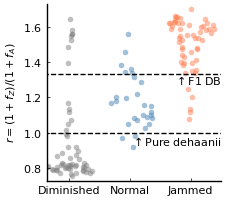

In [6]:
fig=plot(size=(225,200))
Y = resample(response_p)

idx = Y.==1
y = Y[idx]
dotplot!(fig,
    # y .+ rand(Normal(0,0.075),length(y)),
    anc_predictor[idx],
    xticks=([1,2,3],["Diminished","Normal","Jammed"]),
    grid=:off,
    xlims=(-Inf,3.5),
    ylabel=L"r=(1+f_{Z})/(1+f_{A})",
    yguidefontsize=8,
    label="",color=:gray,markerstrokewidth=0,markeralpha=0.5)

idx = Y.==2
y = Y[idx]
dotplot!(fig,
    # y .+ rand(Normal(0,0.075),length(y)),
    anc_predictor[idx],
    label="",color=:steelblue,markerstrokewidth=0,markeralpha=0.5)

idx = Y.==3
y = Y[idx]
dotplot!(fig,
    # y .+ rand(Normal(0,0.075),length(y)),
    anc_predictor[idx],
    label="",color=:coral,markerstrokewidth=0,markeralpha=0.5)

hline!(fig,[1,(1+1)/(1+0.5)],label="",linestyle=:dash,linecolor=:black,)
annotate!(fig,[(3.5,1-0.05,Plots.text(L"\uparrow\mathrm{Pure\;dehaanii}",8,:right)),
        (3.5,(1+1)/(1+0.5)-0.04,Plots.text(L"\uparrow\mathrm{F1\;DB}",8,:right))])

In [312]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/ancestry_ratio_results"

savefig(fig,"$(dir_output)/SampleScattered_by_r.pdf")
savefig(fig,"$(dir_output)/SampleScattered_by_r.png")

In [271]:
idx2 = (anc_predictor .>= 1) .& (anc_predictor.<= (1+1)/(1+0.5))
idx1 = (anc_predictor .< 1) 
idx3 = (anc_predictor .> (1+1)/(1+0.5))

prob_11 = []
prob_21 = []
prob_31 = []
prob_12 = []
prob_22 = []
prob_32 = []
prob_13 = []
prob_23 = []
prob_33 = []

K = 1000
for k in 1:K
    y = resample(response_p)
    push!(prob_11, sum(y[idx1] .== 1)/sum(idx1))
    push!(prob_21, sum(y[idx1] .== 2)/sum(idx1))
    push!(prob_31, sum(y[idx1] .== 3)/sum(idx1))
    
    push!(prob_12, sum(y[idx2] .== 1)/sum(idx2))
    push!(prob_22, sum(y[idx2] .== 2)/sum(idx2))
    push!(prob_32, sum(y[idx2] .== 3)/sum(idx2))
    
    push!(prob_13, sum(y[idx3] .== 1)/sum(idx3))
    push!(prob_23, sum(y[idx3] .== 2)/sum(idx3))
    push!(prob_33, sum(y[idx3] .== 3)/sum(idx3))
end

In [283]:
p1 = [mean(prob_11),mean(prob_12),mean(prob_13)]
p2 = [mean(prob_21),mean(prob_22),mean(prob_23)]
p3 = [mean(prob_31),mean(prob_32),mean(prob_33)]

3-element Vector{Float64}:
 0.010893617021276508
 0.13316666666666732
 0.785446153846142

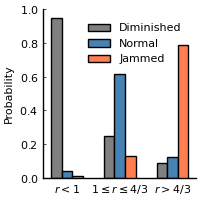

In [309]:
fig = plot(size=(200,200))
x=1
dx=0.2
dX = 1
bar!(fig,[x,x+dX,x+2*dX],p1,
    bar_width=dx,label="Diminished",color=:gray,
    ylims=(0,1),
    ylabel="Probability",
    yguidefontsize=8,
    legend_background_color=false,
    grid=:off,
    xticks=([x+dx,x+dX+dx,x+dX*2+dx],[L"r<1",L"1\leq r\leq4/3",L"r>4/3"]),
    )
bar!(fig,[x,x+dX,x+2*dX].+dx,p2,
    bar_width=dx,label="Normal",color=:steelblue)
bar!(fig,[x,x+dX,x+2*dX].+2*dx,p3,
    bar_width=dx,label="Jammed",color=:coral)

In [310]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/ancestry_ratio_results"

savefig(fig,"$(dir_output)/Probabilities_by_r.pdf")
savefig(fig,"$(dir_output)/Probabilities_by_r.png")

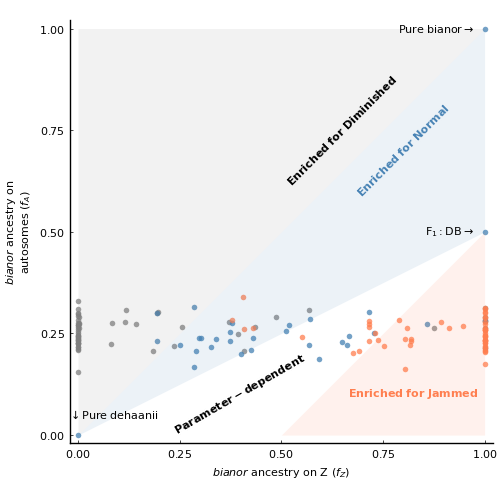

In [44]:
fig=plot(size=(500,500))
Y = resample(response_p)

idx = Y.==1
y = Y[idx]

scatter!(fig,anc_Z[idx],anc_A[idx],
    xlims=(-0.02,1.02),
    ylims=(-0.02,1.02),
    aspect_ratio=1,
    grid=:off,
    xlabel=string(L"bianor"," ancestry on Z ",L"(f_{Z})"),
    ylabel=string(L"bianor"," ancestry on\nautosomes ",L"(f_{A})"),
    xguidefontsize=8,
    yguidefontsize=8,
    label="",color=:gray,markerstrokewidth=0,markeralpha=0.75)

idx = Y.==2
y = Y[idx]

scatter!(fig,anc_Z[idx],anc_A[idx],
    label="",color=:steelblue,markerstrokewidth=0,markeralpha=0.75)

idx = Y.==3
y = Y[idx]

scatter!(fig,anc_Z[idx],anc_A[idx],
    label="",color=:coral,markerstrokewidth=0,markeralpha=0.75)

scatter!(fig,[0,1,1],[0,1,0.5],
    label="",color=:steelblue,markerstrokewidth=0,markeralpha=0.75)

y1_f(x)=x
# y2_f(x)=3/4*(1+x)-1
y2_f(x)=x/2
y3_f(x)=x-0.5

plot!(fig,[0,1],[0,1],fillrange=y2_f.([0,1]),fillcolor=:steelblue,linewidth=0,fillalpha=0.1,label="",linecolor=:black,)
plot!(fig,[0,1],[0,1],fillrange=[1,1],fillcolor=:gray,fillalpha=0.1,linewidth=0,label="",linecolor=:black,)

plot!(fig,[1/3,1],[0,0.5],label="",linewidth=0,linecolor=:black,)
plot!(fig,[0.5,1],[0,0.5],fillrange=[0,0],fillalpha=0.1,fillcolor=:coral,linewidth=0,label="",linecolor=:black,)

annotate!(fig,[(0.975,1,Plots.text(L"\mathrm{Pure\;bianor}\rightarrow",8,:right))])
annotate!(fig,[(-0.025,0.05,Plots.text(L"\downarrow\mathrm{Pure\;dehaanii}",8,:left))])
annotate!(fig,[(0.975,0.5,Plots.text(L"\mathrm{F_1: DB}\rightarrow",8,:right))])

# for (1+fZ)/(1+fA)
# annotate!(fig,[(0.8,0.7,Plots.text(L"\mathbf{1\leq r\leq 4/3}",8,rotation=45))])
# annotate!(fig,[(0.85,0.1,Plots.text(L"\mathbf{r> 4/3}",8,rotation=45,))])
# annotate!(fig,[(0.7,0.8,Plots.text(L"\mathbf{r<1}",8,rotation=45))])


# for general form (k+fZ)/(k+fA)
annotate!(fig,[(0.65,0.75,Plots.text(L"\mathbf{Enriched\;for\;Diminished}",8,rotation=45))])
annotate!(fig,[(0.8,0.7,Plots.text(L"\mathbf{Enriched\;for\;Normal}",8,:steelblue,rotation=45))])
annotate!(fig,[(0.825,0.1,Plots.text(L"\mathbf{Enriched\;for\;Jammed}",8,:coral,rotation=0,))])
annotate!(fig,[(0.4,0.1,Plots.text(L"\mathbf{Parameter-dependent}",8,:black,rotation=30,))])



In [ ]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/ancestry_ratio_results"

savefig(fig,"$(dir_output)/fZ_fA_plot_general.pdf")
savefig(fig,"$(dir_output)/fZ_fA_plot_general.png")

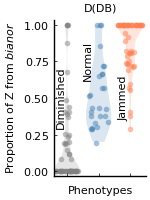

In [34]:
fig=plot(size=(150,200))
Y = resample(response_p)

idx = Y.==1
y = Y[idx]
dotplot!(fig,
    # y .+ rand(Normal(0,0.075),length(y)),
    [1],
    anc_Z[idx],
    xticks=([1,2,3],["","",""]),
    xlabel="Phenotypes",
    xguidefontsize=8,
    grid=:off,
    xlims=(-Inf,3.5),
    # ylims=(-0.05,1.3),
    title="D(DB)",
    titlefontsize=8,
    ylabel=L"\mathrm{Proportion\;of\;Z\;from\;}bianor",
    yguidefontsize=8,
    label="",color=:gray,markerstrokewidth=0,markeralpha=0.5)

violin!(fig,
    # y .+ rand(Normal(0,0.075),length(y)),
    [1],
    anc_Z[idx],
    grid=:off,
    label="",color=:gray,fillalpha=0.2,linewidth=0,)

idx = Y.==2
y = Y[idx]
dotplot!(fig,
    [2],
    # y .+ rand(Normal(0,0.075),length(y)),
    anc_Z[idx],
    label="",color=:steelblue,markerstrokewidth=0,markeralpha=0.5)

violin!(fig,
    # y .+ rand(Normal(0,0.075),length(y)),
    [2],
    anc_Z[idx],
    grid=:off,
    label="",color=:steelblue,fillalpha=0.2,linewidth=0,)

idx = Y.==3
y = Y[idx]
dotplot!(fig,
    [3],
    # y .+ rand(Normal(0,0.075),length(y)),
    anc_Z[idx],
    label="",color=:coral,markerstrokewidth=0,markeralpha=0.5)

violin!(fig,
    # y .+ rand(Normal(0,0.075),length(y)),
    [3],
    anc_Z[idx],
    grid=:off,
    label="",color=:coral,fillalpha=0.2,linewidth=0,)

annotate!(fig,[(0.8,0.5,Plots.text("Diminished",8,rotation=90)),
        (1.65,0.75,Plots.text("Normal",8,rotation=90)),
        (2.8,0.5,Plots.text("Jammed",8,rotation=90))
        ])

# hline!(fig,[1,(1+1)/(1+0.5)],label="",linestyle=:dash,linecolor=:black,)
# annotate!(fig,[(3.5,1-0.05,Plots.text(L"\uparrow\mathrm{Pure\;dehaanii}",8,:right)),
        # (3.5,(1+1)/(1+0.5)-0.04,Plots.text(L"\uparrow\mathrm{F1\;DB}",8,:right))])

In [35]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/ancestry_ratio_results"

savefig(fig,"$(dir_output)/SampleScattered_by_ZAncestry.pdf")
savefig(fig,"$(dir_output)/SampleScattered_by_ZAncestry.png")

In [ ]:
## using anc_z-anc_A


rZA = anc_Z .- anc_A

# boundaries
w = 0.15
r_L = Array(-0.5:w/5:1.0)
r_R = r_L .+ w

N_repeats = 1000

p1_r_all=[]
p2_r_all=[]
p3_r_all=[]


for i in 1:N_repeats
    
    Y = resample(response_p)
    
    idx1 = Y .== 1
    idx2 = Y .== 2
    idx3 = Y .== 3

    N = size(Y)[1]

    N1 = sum(idx1)
    N2 = sum(idx2)
    N3 = sum(idx3)

    p1 = N1/N
    p2 = N2/N
    p3 = N3/N

    pr_1 = [sum((rZA[idx1] .>= r_L[j]) .& (rZA[idx1] .< r_R[j]))/N1 for j in 1:size(r_L)[1]]
    pr_2 = [sum((rZA[idx2] .>= r_L[j]) .& (rZA[idx2] .< r_R[j]))/N2 for j in 1:size(r_L)[1]]
    pr_3 = [sum((rZA[idx3] .>= r_L[j]) .& (rZA[idx3] .< r_R[j]))/N3 for j in 1:size(r_L)[1]]
    
    
    p1_r = pr_1 .* p1 ./ (pr_1 .* p1 .+ pr_2 .* p2 + pr_3 .* p3)
    p2_r = pr_2 .* p2 ./ (pr_1 .* p1 .+ pr_2 .* p2 + pr_3 .* p3)
    p3_r = pr_3 .* p3 ./ (pr_1 .* p1 .+ pr_2 .* p2 + pr_3 .* p3)
    
    push!(p1_r_all,p1_r)
    push!(p2_r_all,p2_r)
    push!(p3_r_all,p3_r)
    
end

p1_r = mean(hcat(p1_r_all...),dims=2)[:,1]
p1_ste = std(hcat(p1_r_all...),dims=2)[:,1]
p2_r = mean(hcat(p2_r_all...),dims=2)[:,1]
p2_ste = std(hcat(p2_r_all...),dims=2)[:,1]
p3_r = mean(hcat(p3_r_all...),dims=2)[:,1]
p3_ste = std(hcat(p3_r_all...),dims=2)[:,1]


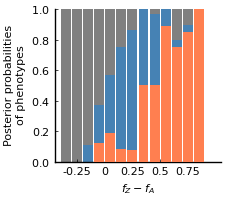

In [6]:
fig = plot(size=(225,200))

x = (r_L .+ r_R)./2

bar!(fig,x,p3_r .+ p2_r .+ p1_r,
    color=:gray,bar_width=w*0.9,linewidth=0,label="",
    grid=:off,
    ylims=(0,1),
    xticks=([-0.25,0,0.25,0.5,0.75],["-0.25","0","0.25","0.5","0.75"]),
    xlims=(-Inf,+Inf),
    xlabel=L"f_Z-f_A",
    ylabel="Posterior probabilities\nof phenotypes",
    xguidefontsize=8,
    yguidefontsize=8,
)
bar!(fig,x,p2_r .+ p3_r,
    color=:steelblue,bar_width=w*0.9,linewidth=0,label="")
bar!(fig,x,p3_r,
    color=:coral,bar_width=w*0.9,linewidth=0,label="")

In [7]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/ancestry_ratio_results"

savefig(fig,"$(dir_output)/Posterior_phenotypes_on_DifferenceZA.pdf")
savefig(fig,"$(dir_output)/Posterior_phenotypes_on_DifferenceZA.png")

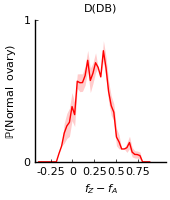

In [69]:
fig = plot(size=(170,200))

x = (r_L .+ r_R)./2

plot!(fig,x,p2_r,
    grid=:off,
    ylims=(0,1),
    xticks=([-0.25,0,0.25,0.5,0.75],["-0.25","0","0.25","0.5","0.75"]),
    yticks=([0,1],["0","1"]),
    xlims=(-Inf,+Inf),
    xlabel=L"f_Z-f_A",
    ylabel=L"\mathrm{\mathbb{P}}(\mathrm{Normal\;\;ovary})",
    label="",
    title="D(DB)",
    titlefontsize=8,
    linecolor=:red,
    xguidefontsize=8,
    yguidefontsize=8,

)

plot!(fig,x,p2_ste .+ p2_r,
    label="",
    linewidth=0,
    fillrange=p2_r .- p2_ste ,
    fillcolor=:red,
    fillalpha=0.2,
)

In [70]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/ancestry_ratio_results"

savefig(fig,"$(dir_output)/Posterior_phenotypes_ofNormal_on_DifferenceZA.pdf")
savefig(fig,"$(dir_output)/Posterior_phenotypes_ofNormal_on_DifferenceZA.png")

# 4. Can Z-ancestry explain pupal weight phenotype?

In [6]:
using Statistics,GLM
using StatsPlots

In [7]:
function get_ancestry_chr_interval(chr,g_all,l_all,interval)
    g = g_all["$(chr)"]
    l = l_all["$(chr)"]
    idx = (l .>= interval[1]) .& (l .< interval[2])
    δl = vcat(l[idx],interval[2:2]) .- vcat(interval[1:1],l[idx])
    if idx[1] > 1
        return g[:,vcat([idx[1]-1],idx)] * δl ./sum(δl) 
    else
        δl = δl[2:end]
        return g[:,idx] * δl ./sum(δl)  
    end
end

get_ancestry_chr_interval (generic function with 1 method)

In [14]:
## these pure species data are alst provided from the code blocks way down!

dir_source = "/n/home00/txiong/Research/2022_HybridSterility/Phenotypes"

dfB = DataFrame(CSV.File("$(dir_source)/pupal_weight_B.txt",header=false))
dfD = DataFrame(CSV.File("$(dir_source)/pupal_weight_D.txt",header=false))

w_fB = dfB[!,2][dfB[!,1] .== "F"]
w_fD = dfD[!,2][dfD[!,1] .== "F"]
w_fB = w_fB[.!ismissing.(w_fB)]
w_fD = w_fD[.!ismissing.(w_fD)];

┌ Warning: thread = 1 warning: parsed expected 2 columns, but didn't reach end of line around data row: 13. Parsing extra columns and widening final columnset
└ @ CSV /n/home00/txiong/.julia/packages/CSV/0Elut/src/file.jl:578


## 4.1. Working on D(DB) pupal weight

In [63]:
## get raw data
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data"

# dir_sub = "matB/run.pheno_pupalWeight_BBD"
dir_sub = "matD/run.pheno_pupalWeight"


chr_size = readdlm("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/06_polished.genome/chr_size.txt")
chr_size = chr_size[:,1] ./1E6

geno = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/genotypes.csv"))[!,2:end]
pmap = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/map.physical.csv"))
gmap = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/map.genetic.csv"))
covar = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/covariates.csv"))
pheno = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/phenotypes.csv"));

g = Array(geno .== "DB") .* 1/2 .+ Array(geno .== "DD") .* 0
co = covar[:,2]
p = pheno[!,:Pupal_Weight]

p_maternal = w_fD;

In [64]:
g_all = Dict()
l_all = Dict()
for chr in 1:30
    g_all["$(chr)"] = g[:,pmap[:,2] .== chr]
    l_all["$(chr)"] = pmap[:,3][pmap[:,2] .== chr]
end

In [65]:
function get_ancestry_chrs(chr_list,g_all,l_all,chr_size)
    chr = chr_list[1]
    cumulative_anc = zeros(size(g_all["$(chr)"])[1])
    L = 0
    for chr in chr_list
        δl = vcat(l_all["$(chr)"][2:end],[chr_size[chr]]) .- l_all["$(chr)"]
        cumulative_anc = cumulative_anc .+ g_all["$(chr)"] * (δl)
        L = L + sum(δl)
    end
    return cumulative_anc ./ L
end

get_ancestry_chrs (generic function with 1 method)

In [66]:
anc_A = get_ancestry_chrs(1:29,g_all,l_all,chr_size)
anc_Z = get_ancestry_chrs([30],g_all,l_all,chr_size) .* 2;

#### Preprocessing and visualization

In [67]:
# controlling for seasonal variation

data = DataFrame(y = p, x_co = co, x_Z = anc_Z)
ols = lm(@formula(y ~ x_co + x_Z), data)

println(ols)

# adjusting observation by removing the effect of brood

## choose one of the following for analyzing either DDB or BBD
p_adjusted = p .- coef(ols)[2] .* (co .== "II"); # for DDB
# p_adjusted = p .+ coef(ols)[2] .* (co .== "I"); # for BBD

## regress again

data = DataFrame(y = p_adjusted, x_Z = anc_Z)
ols = lm(@formula(y ~ x_Z), data)

println(ols)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x_co + x_Z

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error       t  Pr(>|t|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   1.83945     0.0455048   40.42    <1e-75   1.74944    1.92947
x_co: II     -0.0627604   0.0437726   -1.43    0.1540  -0.149347   0.0238262
x_Z          -1.00302     0.0544152  -18.43    <1e-37  -1.11066   -0.895378
────────────────────────────────────────────────────────────────────────────
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x_Z

Coefficients:
───────────────────────────────────────────────

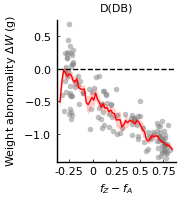

In [68]:
## plot deviation from the pure maternal species weight

xdata = anc_Z .- anc_A
ydata = p_adjusted .- mean(p_maternal)

wid = 0.1
x_l = -0.4:wid/5:0.8
x_r = x_l .+ wid

x_mid = (x_r.+x_l)/2
ymean = [mean(ydata[(xdata .<= x_r[i]) .& (xdata .> x_l[i])]) for i in 1:size(x_l)[1]]
yste = begin
    
    σ = [std(ydata[(xdata .<= x_r[i]) .& (xdata .> x_l[i])]) for i in 1:size(x_l)[1]]
    n = [length(ydata[(xdata .<= x_r[i]) .& (xdata .> x_l[i])]) for i in 1:size(x_l)[1]]
    σ ./ sqrt.(n)
end

x_mid = x_mid[.!isnan.(ymean)]
yste = yste[.!isnan.(ymean)]
ymean = ymean[.!isnan.(ymean)]


fig = plot(size=(180,200))


scatter!(fig,anc_Z .- anc_A ,p_adjusted .- mean(p_maternal),
    markerstrokewidth=0,
    markercolor=:gray,
    markeralpha=0.5,
    label="",
    title="D(DB)",
    titlefontsize=8,
    xguidefontsize=8,
    yguidefontsize=8,
    grid=:off,
    xticks=([-0.25,0,0.25,0.5,0.75],["-0.25","0","0.25","0.5","0.75"]),
    ylabel=string("Weight abnormality ",L"\Delta W"," (g)"),
    xlabel=L"f_Z-f_A",
)


plot!((x_r.+x_l)/2,ymean,
    color=:red,
    linestyle=:solid,
    label="")

plot!((x_r.+x_l)/2,ymean.+yste,
    fillrange=ymean.-yste,
    fillcolor=:red,
    fillalpha=0.2,
    linewidth=0,label="")

hline!(fig,[0],linecolor=:black,linestyle=:dash,label="")

In [ ]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_pupalWeight"

savefig(fig,"$(dir_output)/WeightAbnormality_DancZancA_regression.png")
savefig(fig,"$(dir_output)/WeightAbnormality_DancZancA_regression.pdf")

#### Regression-based power analysis

In [69]:
data = DataFrame(y = p, x_co = co, x_Z = anc_Z)
ols = lm(@formula(y ~ x_co + x_Z), data)
R2_Z_anc = r2(ols)

## the following is for DDB
ols

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x_co + x_Z

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error       t  Pr(>|t|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   1.83945     0.0455048   40.42    <1e-75   1.74944    1.92947
x_co: II     -0.0627604   0.0437726   -1.43    0.1540  -0.149347   0.0238262
x_Z          -1.00302     0.0544152  -18.43    <1e-37  -1.11066   -0.895378
────────────────────────────────────────────────────────────────────────────

In [70]:
## adjusting observation by removing the effect of brood

p_adjusted = p .- coef(ols)[2] .* (co .== "II");

## doing linear regression on adjusted p without considering covariates

data = DataFrame(y = p_adjusted, x_Z = anc_Z)
ols = lm(@formula(y ~ x_Z), data)
R2_Z_anc = r2(ols)

0.7247579087214295

In [71]:
R2_1qtl = []
for i in 1:size(g_all["30"])[2]
    data = DataFrame(y = p_adjusted, x_Z = g_all["30"][:,i].*2)
    push!(R2_1qtl, r2(lm(@formula(y ~ x_Z),data)))
end

R2_2qtl = zeros(size(g_all["30"])[2],size(g_all["30"])[2]) .+ NaN

for i in 1:size(g_all["30"])[2]
    for j in (i+1):size(g_all["30"])[2]
        data = DataFrame(y = p_adjusted, x_Z1 = g_all["30"][:,i].*2, x_Z2 = g_all["30"][:,j].*2)
        R2_2qtl[i,j] = r2(lm(@formula(y ~ x_Z1 + x_Z2),data))
    end
end

theory_curve_1(l)=3/8*(1-2*(l-1)*l)^2
theory_curve_2(l1,l2)=3/4*(2*abs(l1 - l2)*(l1 + l2 - 1)^2 + (1 + 2*l1*(1 - l1))*(1+ 
        2*l2*(1-l2)))/(2-abs(l1 - l2))

theory_curve_3(l1,l2,l3)=(3*((1+2*(1-l3)*l3)^2*abs(l1 - l2)^2 + 
     abs(l1-l3)*(8*(l1 - l2)*(-1+l1+l2)*(l2-l3)*(-1+l2+ 
           l3)+(1+2*(1-l2)*l2)^2*abs(l1 - l3)) - 
     2*(4*(l1 - l2)*(-1+l1+l2)*(l1-l3)*(-1+l1+l3)+(1+ 
           2*(1-l1)*l1)*(1+2(1-l2)*l2)*abs(l1 - l3))*abs(l2 - l3)+
        (1+2*(1-l1)*l1)^2*abs(l2-l3)^2- 
     2*abs(l1-l2)*(4*(l1-l3)*(l2-l3)*(-1+l1+l3)*(-1+l2+ 
           l3)+(1+2*(1-l2)*l2)*(1+2*(1-l3)*l3)*abs(l1 - l3)+
            (1+2*(1-l1)*l1)*(1+2*(1-l3)*l3)*abs(l2 - l3))))/(8*(abs(l1-l2)^2+
        (abs(l1-l3)-abs(l2-l3))^2+2*abs(l1 - l2)*(abs(l1 - l3)*(-1+abs(l2-l3))-abs(l2-l3))))

theory_curve_3 (generic function with 1 method)

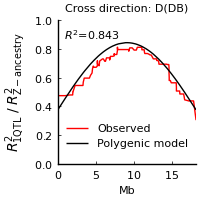

In [72]:
x = pmap[:,3][end-163:end]
y_predicted = theory_curve_1.(x./x[end])
y_observed = R2_1qtl ./ R2_Z_anc

R2_y = round(1-sum((y_predicted.-y_observed).^2)/sum((y_observed .- mean(y_observed)).^2),digits=3)

fig = plot(size=(200,200))
plot!(fig,x,y_observed,color=:red,
    ylims=(0,1),xlims=(0,+Inf),
    xlabel="Mb",
    ylabel=L"R^2_{\mathrm{1QTL}}\;/\;R^2_{\mathrm{Z-ancestry}}",
    yguidefontsize=10,
    xguidefontsize=8,
    legend=:bottom,
    legend_background_color=false,
    label="Observed",
    grid=:off,
    title="Cross direction: D(DB)",
    titlefontsize=8,
    )
plot!(fig,x,y_predicted,color=:black,
    label="Polygenic model",
    )
annotate!(fig,[(4.5,0.9,Plots.text(string(L"R^2","=$(R2_y)"),8))])

In [ ]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_pupalWeight"


savefig(fig,"$(dir_output)/polygenic_model.1QTL.fit.png")
savefig(fig,"$(dir_output)/polygenic_model.1QTL.fit.pdf")

In [73]:
x = pmap[:,3][end-163:end]

y_predicted_2qtl = zeros(size(g_all["30"])[2],size(g_all["30"])[2]) .+ NaN

for i in 1:size(g_all["30"])[2]
    for j in (i+1):size(g_all["30"])[2]
        y_predicted_2qtl[j,i] = theory_curve_2(x[j]./x[end],x[i]./x[end])
    end
end

y_observed_reshaped = reshape(R2_2qtl ./ R2_Z_anc,length(R2_2qtl))
y_predicted_2qtl_reshaped = reshape(transpose(y_predicted_2qtl),length(transpose(y_predicted_2qtl)))

y_observed_reshaped = y_observed_reshaped[.!isnan.(y_observed_reshaped)]
y_predicted_2qtl_reshaped = y_predicted_2qtl_reshaped[.!isnan.(y_predicted_2qtl_reshaped)]

R2_y = round(1-sum((y_predicted_2qtl_reshaped .- y_observed_reshaped).^2)/sum((y_observed_reshaped .- mean(y_observed_reshaped)).^2),digits=3)


0.845

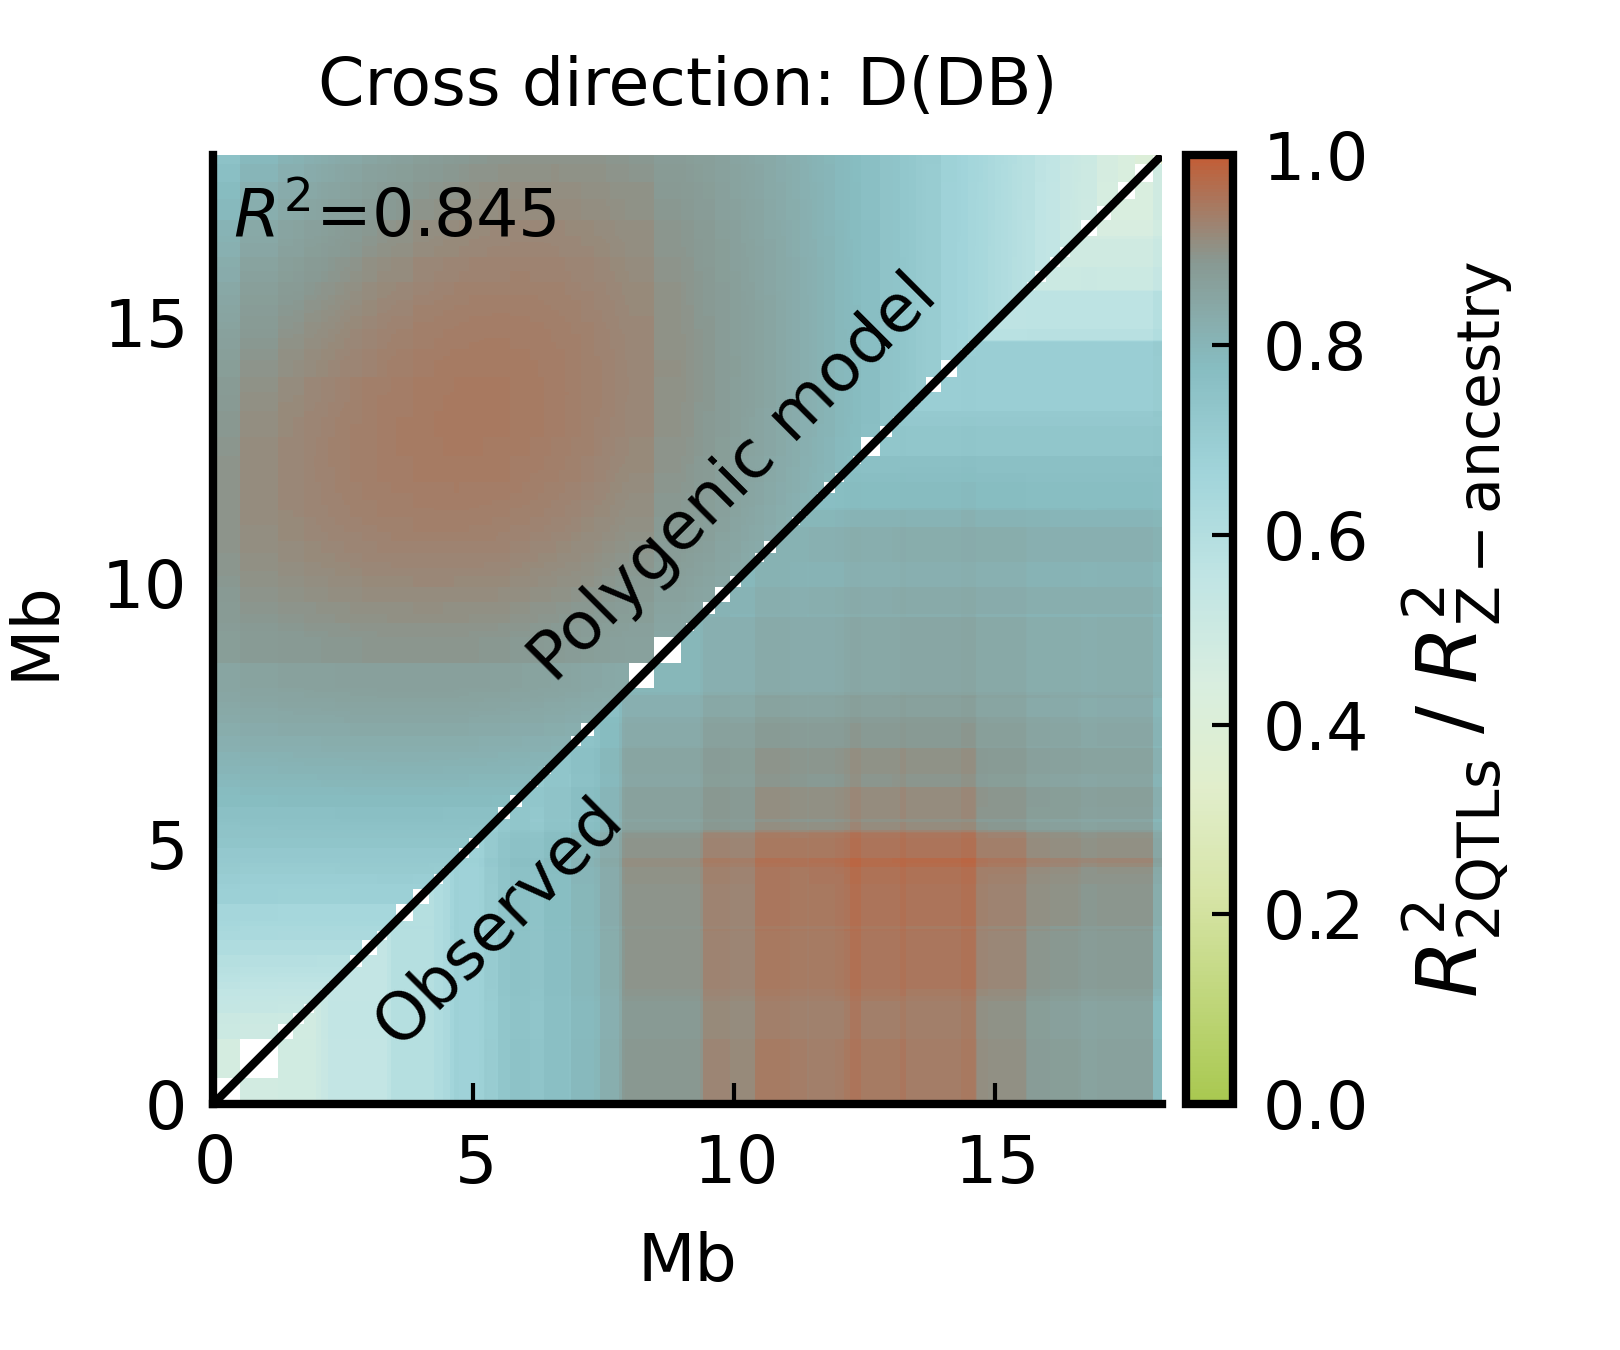

In [74]:
fig = plot(size=(270,225))

c = cgrad(:island,rev=true)
heatmap!(fig,x,x,R2_2qtl ./ R2_Z_anc,color=c,clims=(0,1),
    xlims=(0,+Inf),
    ylims=(0,+Inf),
    xlabel="Mb",
    ylabel="Mb",
    grid=:off,
    xguidefontsize=8,
    yguidefontsize=8,
    title="Cross direction: D(DB)",
    colorbar_title=L"R^2_{\mathrm{2QTLs}}\;/\;R^2_{\mathrm{Z-ancestry}}",
    colorbar_titlefontsize=10,
    titlefontsize=8,
    dpi=600,
    aspect_ratio=1)
heatmap!(fig,x,x,y_predicted_2qtl,color=c,format=:png,)
plot!(fig,[0,x[end]],[0,x[end]],label="",linestyle=:solid,linecolor=:black,)

annotate!(fig,[(5.5,3.5,Plots.text("Observed",8,rotation=45))])
annotate!(fig,[(10,12,Plots.text("Polygenic model",8,rotation=45))])

annotate!(fig,[(3.5,17,Plots.text(string(L"R^2","=$(R2_y)"),8))])

In [ ]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_pupalWeight"


savefig(fig,"$(dir_output)/polygenic_model.2QTL.fit.png")
savefig(fig,"$(dir_output)/polygenic_model.2QTL.fit.pdf")

In [75]:
# run 3-qtl scan on a specific mid-marker

R2_3qtl_slice_all = Dict()
X_left = Dict()
X_right = Dict()
X_mid = Dict()

for i in 1:9

    n_total_markers = size(g_all["30"])[2]

    idx_mid_marker = Int(round(n_total_markers/10*i))

    R2_3qtl_slice = zeros(n_total_markers - idx_mid_marker,idx_mid_marker - 1)

    I = 1:(idx_mid_marker - 1)
    J = (idx_mid_marker+1) : n_total_markers

    for i in 1:size(I)[1]
        for j in 1:size(J)[1]
            data = DataFrame(y = p_adjusted, x_Z1 = g_all["30"][:,I[i]].*2, x_Z2 = g_all["30"][:,idx_mid_marker].*2, x_Z3 = g_all["30"][:,J[j]].*2)
            R2_3qtl_slice[j,i] = r2(lm(@formula(y ~ x_Z1 + x_Z2 + x_Z3),data))
        end
    end
    
    x_left = pmap[:,3][end-163:end][1:size(I)[1]]

    x_mid = round(pmap[:,3][end-163:end][idx_mid_marker];digits=2)

    x_right = pmap[:,3][end-163:end][end-size(J)[1]+1 : end]
    
    R2_3qtl_slice_all["$i"] = R2_3qtl_slice
    
    X_left["$i"] = x_left
    X_mid["$i"] = x_mid
    X_right["$i"] = x_right
    
end

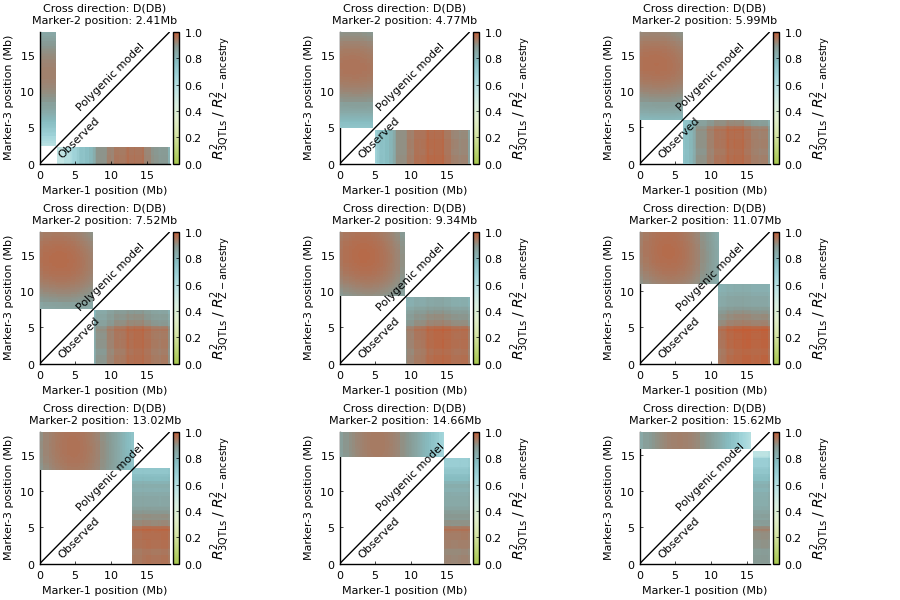

In [76]:
fig = plot(size=(900,600),layout=(3,3))

c = cgrad(:island,rev=true)

l_rightmost = pmap[:,3][end-163:end][end]

for i in 1:9

R2_3qtl_slice = R2_3qtl_slice_all["$i"]
x_left = X_left["$i"]
x_mid = X_mid["$i"]
x_right = X_right["$i"]
    
L1 = transpose(hcat(repeat([x_left],size(x_right)[1])...))
L3 = hcat(repeat([x_right],size(x_left)[1])...)
    

predicted_R2_3qtl = theory_curve_3.(L1./l_rightmost,x_mid/l_rightmost,L3./l_rightmost)

heatmap!(fig,x_right,x_left,transpose(R2_3qtl_slice ./ R2_Z_anc),color=c,clims=(0,1),
    xlims=(0,pmap[:,3][end-163:end][end]),
    ylims=(0,pmap[:,3][end-163:end][end]),
    xlabel="Marker-1 position (Mb)",
    ylabel="Marker-3 position (Mb)",
    grid=:off,
    xguidefontsize=8,
    yguidefontsize=8,
    title="Cross direction: D(DB)\nMarker-2 position: $(x_mid)Mb",
    colorbar_title=L"R^2_{\mathrm{3QTLs}}\;/\;R^2_{\mathrm{Z-ancestry}}",
    colorbar_titlefontsize=10,
    titlefontsize=8,
    # dpi=600,
    subplot=i,
    # aspect_ratio=1,
    )

heatmap!(fig,x_left,x_right,predicted_R2_3qtl,color=c,clims=(0,1),
    subplot=i,
    )
    
plot!(fig,[0,l_rightmost],[0,l_rightmost],label="",linestyle=:solid,linecolor=:black,subplot=i)
    
annotate!(fig,[(5.5,3.5,Plots.text("Observed",8,rotation=45))],subplot=i)
annotate!(fig,[(10,12,Plots.text("Polygenic model",8,rotation=45))],subplot=i)
    
end

fig

In [ ]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_pupalWeight"


savefig(fig,"$(dir_output)/polygenic_model.3QTL.fit.png")
savefig(fig,"$(dir_output)/polygenic_model.3QTL.fit.pdf")

## 4.2. Working on B(BD) pupal weight

In [41]:
## get raw data
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data"

dir_sub = "matB/run.pheno_pupalWeight_BBD"
# dir_sub = "matD/run.pheno_pupalWeight"


chr_size = readdlm("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/06_polished.genome/chr_size.txt")
chr_size = chr_size[:,1] ./1E6

geno = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/genotypes.csv"))[!,2:end]
pmap = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/map.physical.csv"))
gmap = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/map.genetic.csv"))
covar = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/covariates.csv"))
pheno = DataFrame(CSV.File("$(dir_source)/$(dir_sub)/phenotypes.csv"));

g = Array(geno .== "DB") .* 1/2 .+ Array(geno .== "BB") .* 0
co = covar[:,2]
p = pheno[!,:Pupal_Weight]

p_maternal = w_fB;

In [43]:
g_all = Dict()
l_all = Dict()
for chr in 1:30
    g_all["$(chr)"] = g[:,pmap[:,2] .== chr]
    l_all["$(chr)"] = pmap[:,3][pmap[:,2] .== chr]
end

In [44]:
function get_ancestry_chrs(chr_list,g_all,l_all,chr_size)
    chr = chr_list[1]
    cumulative_anc = zeros(size(g_all["$(chr)"])[1])
    L = 0
    for chr in chr_list
        δl = vcat(l_all["$(chr)"][2:end],[chr_size[chr]]) .- l_all["$(chr)"]
        cumulative_anc = cumulative_anc .+ g_all["$(chr)"] * (δl)
        L = L + sum(δl)
    end
    return cumulative_anc ./ L
end

get_ancestry_chrs (generic function with 1 method)

In [45]:
anc_A = get_ancestry_chrs(1:29,g_all,l_all,chr_size)
anc_Z = get_ancestry_chrs([30],g_all,l_all,chr_size) .* 2;

#### Preprocessing and visualization

In [46]:
# controlling for seasonal variation

data = DataFrame(y = p, x_co = co, x_Z = anc_Z)
ols = lm(@formula(y ~ x_co + x_Z), data)

println(ols)

# adjusting observation by removing the effect of brood

## choose one of the following for analyzing either DDB or BBD
# p_adjusted = p .- coef(ols)[2] .* (co .== "II"); # for DDB
p_adjusted = p .+ coef(ols)[2] .* (co .== "I"); # for BBD

## regress again

data = DataFrame(y = p_adjusted, x_Z = anc_Z)
ols = lm(@formula(y ~ x_Z), data)

println(ols)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x_co + x_Z

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.71927    0.0537324  13.39    <1e-25   0.612927   0.825613
x_co: IV     0.231014   0.0584464   3.95    0.0001   0.115342   0.346687
x_Z          0.86114    0.0544151  15.83    <1e-30   0.753446   0.968835
────────────────────────────────────────────────────────────────────────
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x_Z

Coefficients:
────────────────────────────────────────────────────────────────────────

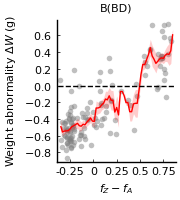

In [47]:
## plot deviation from the pure maternal species weight

xdata = anc_Z .- anc_A
ydata = p_adjusted .- mean(p_maternal)

wid = 0.1
x_l = -0.4:wid/5:0.8
x_r = x_l .+ wid

x_mid = (x_r.+x_l)/2
ymean = [mean(ydata[(xdata .<= x_r[i]) .& (xdata .> x_l[i])]) for i in 1:size(x_l)[1]]
yste = begin
    
    σ = [std(ydata[(xdata .<= x_r[i]) .& (xdata .> x_l[i])]) for i in 1:size(x_l)[1]]
    n = [length(ydata[(xdata .<= x_r[i]) .& (xdata .> x_l[i])]) for i in 1:size(x_l)[1]]
    σ ./ sqrt.(n)
end

x_mid = x_mid[.!isnan.(ymean)]
yste = yste[.!isnan.(ymean)]
ymean = ymean[.!isnan.(ymean)]


fig = plot(size=(180,200))


scatter!(fig,anc_Z .- anc_A ,p_adjusted .- mean(p_maternal),
    markerstrokewidth=0,
    markercolor=:gray,
    markeralpha=0.5,
    label="",
    title="B(BD)",
    titlefontsize=8,
    xguidefontsize=8,
    yguidefontsize=8,
    grid=:off,
    xticks=([-0.25,0,0.25,0.5,0.75],["-0.25","0","0.25","0.5","0.75"]),
    ylabel=string("Weight abnormality ",L"\Delta W"," (g)"),
    xlabel=L"f_Z-f_A",
)


plot!((x_r.+x_l)/2,ymean,
    color=:red,
    linestyle=:solid,
    label="")

plot!((x_r.+x_l)/2,ymean.+yste,
    fillrange=ymean.-yste,
    fillcolor=:red,
    fillalpha=0.2,
    linewidth=0,label="")

hline!(fig,[0],linecolor=:black,linestyle=:dash,label="")

In [ ]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalB/run.pheno_pupalWeight"


savefig(fig,"$(dir_output)/WeightAbnormality_DancZancA_regression.png")
savefig(fig,"$(dir_output)/WeightAbnormality_DancZancA_regression.pdf")

#### Regression-based power analysis

In [55]:
data = DataFrame(y = p, x_co = co, x_Z = anc_Z)
ols = lm(@formula(y ~ x_co + x_Z), data)
R2_Z_anc = r2(ols)

## the following is for BBD
ols

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x_co + x_Z

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.71927    0.0537324  13.39    <1e-25   0.612927   0.825613
x_co: IV     0.231014   0.0584464   3.95    0.0001   0.115342   0.346687
x_Z          0.86114    0.0544151  15.83    <1e-30   0.753446   0.968835
────────────────────────────────────────────────────────────────────────

In [56]:
## adjusting observation by removing the effect of brood

p_adjusted = p .- coef(ols)[2] .* (co .== "IV");

## doing linear regression on adjusted p without considering covariates

data = DataFrame(y = p_adjusted, x_Z = anc_Z)
ols = lm(@formula(y ~ x_Z), data)
R2_Z_anc = r2(ols)

0.6753230868257278

In [57]:
R2_1qtl = []
for i in 1:size(g_all["30"])[2]
    data = DataFrame(y = p_adjusted, x_Z = g_all["30"][:,i].*2)
    push!(R2_1qtl, r2(lm(@formula(y ~ x_Z),data)))
end

R2_2qtl = zeros(size(g_all["30"])[2],size(g_all["30"])[2]) .+ NaN

for i in 1:size(g_all["30"])[2]
    for j in (i+1):size(g_all["30"])[2]
        data = DataFrame(y = p_adjusted, x_Z1 = g_all["30"][:,i].*2, x_Z2 = g_all["30"][:,j].*2)
        R2_2qtl[i,j] = r2(lm(@formula(y ~ x_Z1 + x_Z2),data))
    end
end

theory_curve_1(l)=3/8*(1-2*(l-1)*l)^2
theory_curve_2(l1,l2)=3/4*(2*abs(l1 - l2)*(l1 + l2 - 1)^2 + (1 + 2*l1*(1 - l1))*(1+ 
        2*l2*(1-l2)))/(2-abs(l1 - l2))

theory_curve_3(l1,l2,l3)=(3*((1+2*(1-l3)*l3)^2*abs(l1 - l2)^2 + 
     abs(l1-l3)*(8*(l1 - l2)*(-1+l1+l2)*(l2-l3)*(-1+l2+ 
           l3)+(1+2*(1-l2)*l2)^2*abs(l1 - l3)) - 
     2*(4*(l1 - l2)*(-1+l1+l2)*(l1-l3)*(-1+l1+l3)+(1+ 
           2*(1-l1)*l1)*(1+2(1-l2)*l2)*abs(l1 - l3))*abs(l2 - l3)+
        (1+2*(1-l1)*l1)^2*abs(l2-l3)^2- 
     2*abs(l1-l2)*(4*(l1-l3)*(l2-l3)*(-1+l1+l3)*(-1+l2+ 
           l3)+(1+2*(1-l2)*l2)*(1+2*(1-l3)*l3)*abs(l1 - l3)+
            (1+2*(1-l1)*l1)*(1+2*(1-l3)*l3)*abs(l2 - l3))))/(8*(abs(l1-l2)^2+
        (abs(l1-l3)-abs(l2-l3))^2+2*abs(l1 - l2)*(abs(l1 - l3)*(-1+abs(l2-l3))-abs(l2-l3))))

theory_curve_3 (generic function with 1 method)

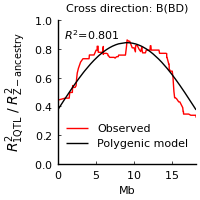

In [58]:
x = pmap[:,3][end-163:end]
y_predicted = theory_curve_1.(x./x[end])
y_observed = R2_1qtl ./ R2_Z_anc

R2_y = round(1-sum((y_predicted.-y_observed).^2)/sum((y_observed .- mean(y_observed)).^2),digits=3)

fig = plot(size=(200,200))
plot!(fig,x,y_observed,color=:red,
    ylims=(0,1),xlims=(0,+Inf),
    xlabel="Mb",
    ylabel=L"R^2_{\mathrm{1QTL}}\;/\;R^2_{\mathrm{Z-ancestry}}",
    yguidefontsize=10,
    xguidefontsize=8,
    legend=:bottom,
    legend_background_color=false,
    label="Observed",
    grid=:off,
    title="Cross direction: B(BD)",
    titlefontsize=8,
    )
plot!(fig,x,y_predicted,color=:black,
    label="Polygenic model",
    )
annotate!(fig,[(4.5,0.9,Plots.text(string(L"R^2","=$(R2_y)"),8))])

In [ ]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalB/run.pheno_pupalWeight"


savefig(fig,"$(dir_output)/polygenic_model.1QTL.fit.png")
savefig(fig,"$(dir_output)/polygenic_model.1QTL.fit.pdf")

In [59]:
x = pmap[:,3][end-163:end]

y_predicted_2qtl = zeros(size(g_all["30"])[2],size(g_all["30"])[2]) .+ NaN

for i in 1:size(g_all["30"])[2]
    for j in (i+1):size(g_all["30"])[2]
        y_predicted_2qtl[j,i] = theory_curve_2(x[j]./x[end],x[i]./x[end])
    end
end

y_observed_reshaped = reshape(R2_2qtl ./ R2_Z_anc,length(R2_2qtl))
y_predicted_2qtl_reshaped = reshape(transpose(y_predicted_2qtl),length(transpose(y_predicted_2qtl)))

y_observed_reshaped = y_observed_reshaped[.!isnan.(y_observed_reshaped)]
y_predicted_2qtl_reshaped = y_predicted_2qtl_reshaped[.!isnan.(y_predicted_2qtl_reshaped)]

R2_y = round(1-sum((y_predicted_2qtl_reshaped .- y_observed_reshaped).^2)/sum((y_observed_reshaped .- mean(y_observed_reshaped)).^2),digits=3)


0.739

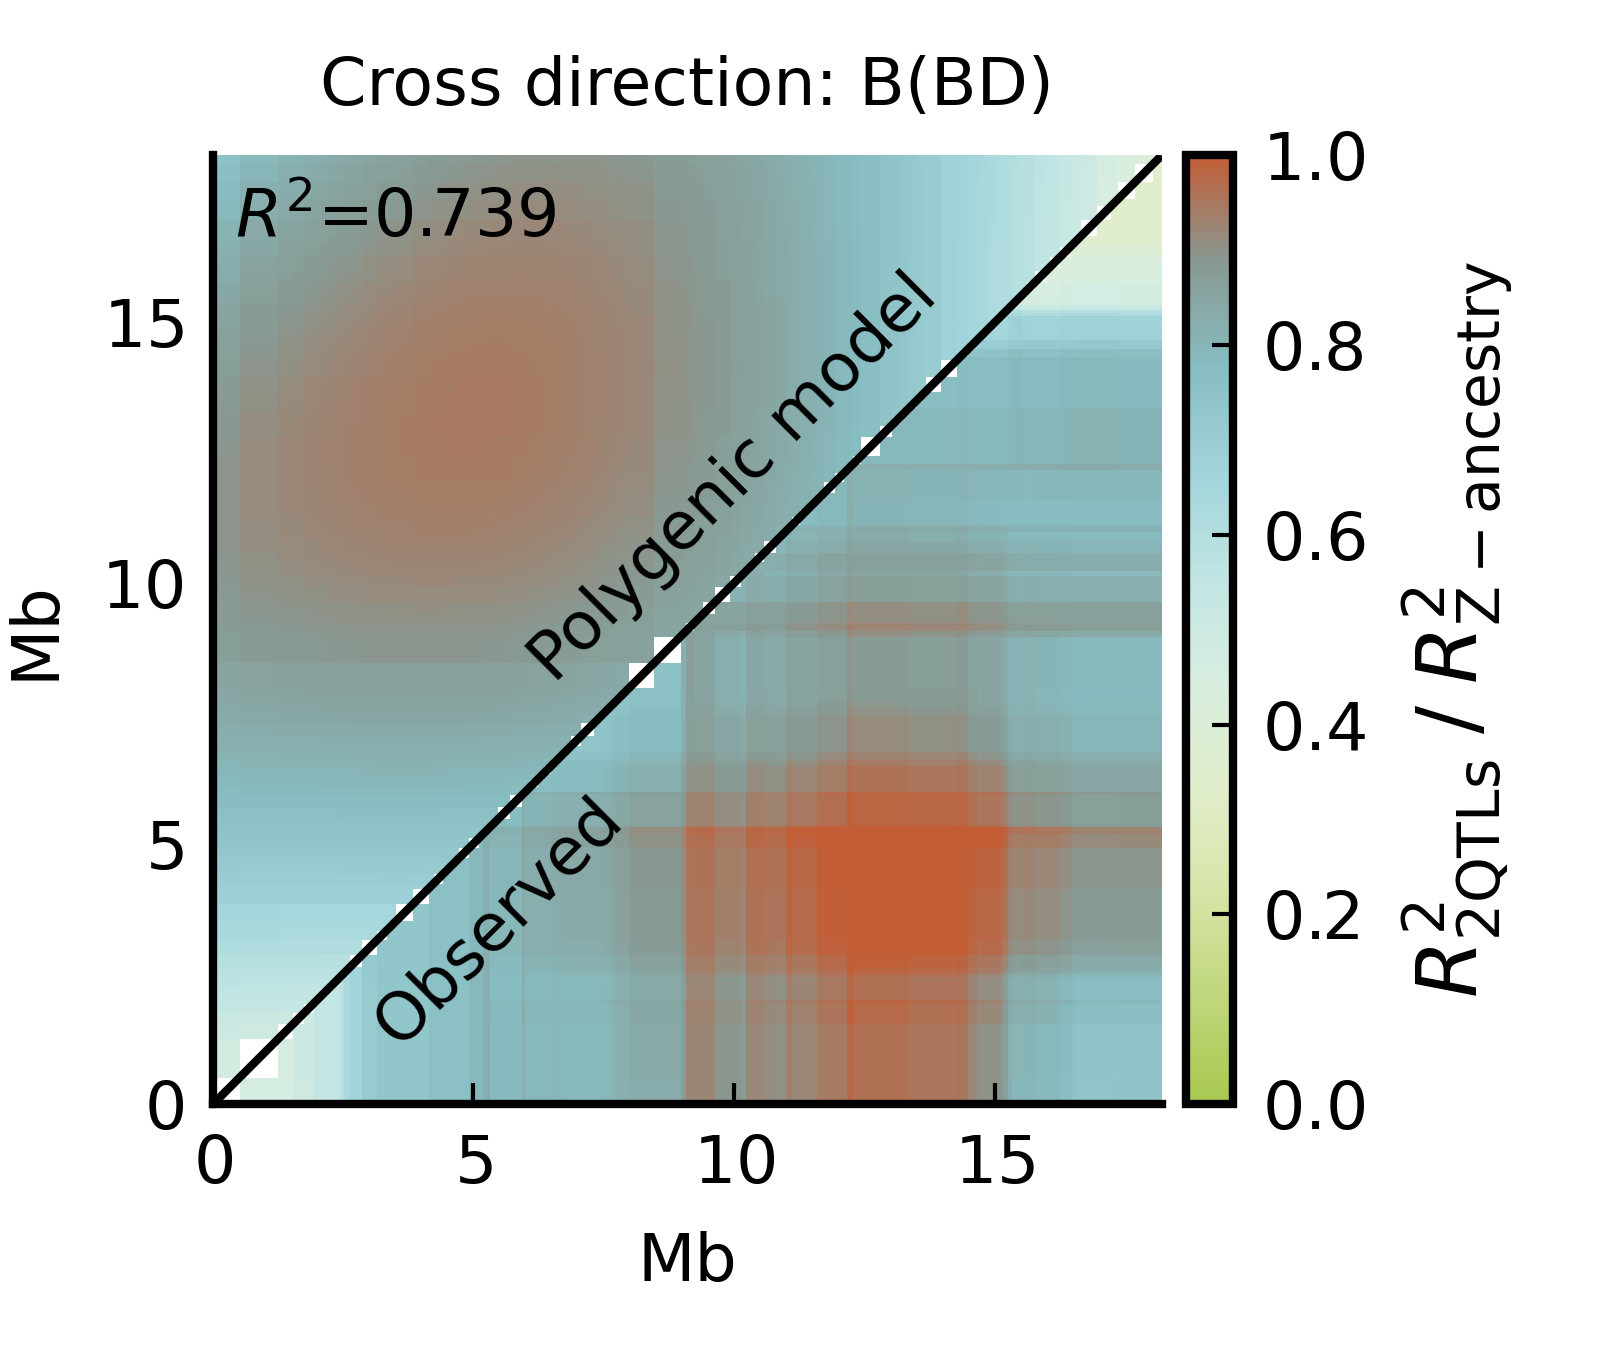

In [60]:
fig = plot(size=(270,225))

c = cgrad(:island,rev=true)
heatmap!(fig,x,x,R2_2qtl ./ R2_Z_anc,color=c,clims=(0,1),
    xlims=(0,+Inf),
    ylims=(0,+Inf),
    xlabel="Mb",
    ylabel="Mb",
    grid=:off,
    xguidefontsize=8,
    yguidefontsize=8,
    title="Cross direction: B(BD)",
    colorbar_title=L"R^2_{\mathrm{2QTLs}}\;/\;R^2_{\mathrm{Z-ancestry}}",
    colorbar_titlefontsize=10,
    titlefontsize=8,
    dpi=600,
    aspect_ratio=1)
heatmap!(fig,x,x,y_predicted_2qtl,color=c,format=:png,)
plot!(fig,[0,x[end]],[0,x[end]],label="",linestyle=:solid,linecolor=:black,)

annotate!(fig,[(5.5,3.5,Plots.text("Observed",8,rotation=45))])
annotate!(fig,[(10,12,Plots.text("Polygenic model",8,rotation=45))])

annotate!(fig,[(3.5,17,Plots.text(string(L"R^2","=$(R2_y)"),8))])

In [ ]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalB/run.pheno_pupalWeight"


savefig(fig,"$(dir_output)/polygenic_model.2QTL.fit.png")
savefig(fig,"$(dir_output)/polygenic_model.2QTL.fit.pdf")

In [61]:
# run 3-qtl scan on a specific mid-marker

R2_3qtl_slice_all = Dict()
X_left = Dict()
X_right = Dict()
X_mid = Dict()

for i in 1:9

    n_total_markers = size(g_all["30"])[2]

    idx_mid_marker = Int(round(n_total_markers/10*i))

    R2_3qtl_slice = zeros(n_total_markers - idx_mid_marker,idx_mid_marker - 1)

    I = 1:(idx_mid_marker - 1)
    J = (idx_mid_marker+1) : n_total_markers

    for i in 1:size(I)[1]
        for j in 1:size(J)[1]
            data = DataFrame(y = p_adjusted, x_Z1 = g_all["30"][:,I[i]].*2, x_Z2 = g_all["30"][:,idx_mid_marker].*2, x_Z3 = g_all["30"][:,J[j]].*2)
            R2_3qtl_slice[j,i] = r2(lm(@formula(y ~ x_Z1 + x_Z2 + x_Z3),data))
        end
    end
    
    x_left = pmap[:,3][end-163:end][1:size(I)[1]]

    x_mid = round(pmap[:,3][end-163:end][idx_mid_marker];digits=2)

    x_right = pmap[:,3][end-163:end][end-size(J)[1]+1 : end]
    
    R2_3qtl_slice_all["$i"] = R2_3qtl_slice
    
    X_left["$i"] = x_left
    X_mid["$i"] = x_mid
    X_right["$i"] = x_right
    
end

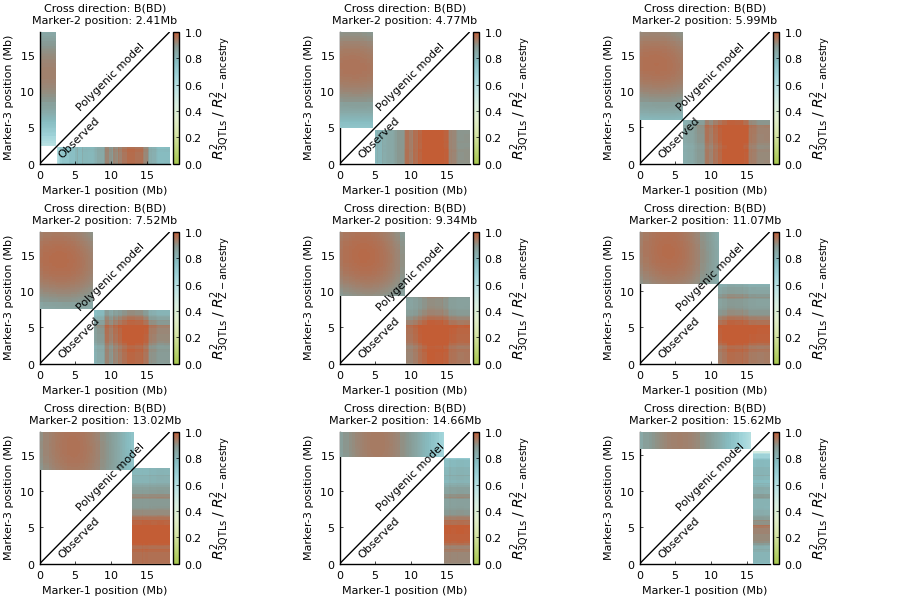

In [62]:
fig = plot(size=(900,600),layout=(3,3))

c = cgrad(:island,rev=true)

l_rightmost = pmap[:,3][end-163:end][end]

for i in 1:9

R2_3qtl_slice = R2_3qtl_slice_all["$i"]
x_left = X_left["$i"]
x_mid = X_mid["$i"]
x_right = X_right["$i"]
    
L1 = transpose(hcat(repeat([x_left],size(x_right)[1])...))
L3 = hcat(repeat([x_right],size(x_left)[1])...)
    

predicted_R2_3qtl = theory_curve_3.(L1./l_rightmost,x_mid/l_rightmost,L3./l_rightmost)

heatmap!(fig,x_right,x_left,transpose(R2_3qtl_slice ./ R2_Z_anc),color=c,clims=(0,1),
    xlims=(0,pmap[:,3][end-163:end][end]),
    ylims=(0,pmap[:,3][end-163:end][end]),
    xlabel="Marker-1 position (Mb)",
    ylabel="Marker-3 position (Mb)",
    grid=:off,
    xguidefontsize=8,
    yguidefontsize=8,
    title="Cross direction: B(BD)\nMarker-2 position: $(x_mid)Mb",
    colorbar_title=L"R^2_{\mathrm{3QTLs}}\;/\;R^2_{\mathrm{Z-ancestry}}",
    colorbar_titlefontsize=10,
    titlefontsize=8,
    # dpi=600,
    subplot=i,
    # aspect_ratio=1,
    )

heatmap!(fig,x_left,x_right,predicted_R2_3qtl,color=c,clims=(0,1),
    subplot=i,
    )
    
plot!(fig,[0,l_rightmost],[0,l_rightmost],label="",linestyle=:solid,linecolor=:black,subplot=i)
    
annotate!(fig,[(5.5,3.5,Plots.text("Observed",8,rotation=45))],subplot=i)
annotate!(fig,[(10,12,Plots.text("Polygenic model",8,rotation=45))],subplot=i)
    
end

fig

In [ ]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalB/run.pheno_pupalWeight"


savefig(fig,"$(dir_output)/polygenic_model.3QTL.fit.png")
savefig(fig,"$(dir_output)/polygenic_model.3QTL.fit.pdf")

## 4.3. Comparing maximum R2 among different models

In [69]:
## D(DB)
R2_2qtl_max_DDB = maximum(R2_2qtl[.!isnan.(R2_2qtl)])
R2_1qtl_max_DDB = maximum(R2_1qtl[.!isnan.(R2_1qtl)])
R2_Z_anc_max_DDB = R2_Z_anc

0.7247579087214295

In [60]:
## B(BD)
R2_2qtl_max_BBD = maximum(R2_2qtl[.!isnan.(R2_2qtl)])
R2_1qtl_max_BBD = maximum(R2_1qtl[.!isnan.(R2_1qtl)])
R2_Z_anc_max_BBD = R2_Z_anc

0.6753230868257278

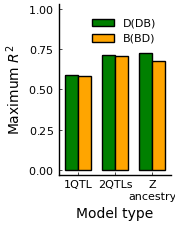

In [94]:
fig = plot(size=(175,225))

x=[1,2,3].*0.7
dx=0.25
bar!(fig,x,[R2_1qtl_max_DDB,R2_2qtl_max_DDB,R2_Z_anc_max_DDB],
    bar_width=0.25,
    legend_background_color=false,
    grid=:off,
    label="D(DB)",
    xticks=(x.+dx/2,["1QTL","2QTLs","Z\nancestry"]),
    ylabel=string("Maximum ",L"R^2"),
    xlabel="Model type",
    xguidefontsize=10,
    yguidefontsize=10,
    color=:green,
    ylims=[0,1],)
bar!(fig,x.+dx,[R2_1qtl_max_BBD,R2_2qtl_max_BBD,R2_Z_anc_max_BBD],
    color=:orange,
    label="B(BD)",
    bar_width=0.25)

In [95]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_pupalWeight"


savefig(fig,"$(dir_output)/model_R2_comparison.png")
savefig(fig,"$(dir_output)/model_R2_comparison.pdf")

#### blockwise ancestry regression

In [126]:
K = 1

a = zeros(size(p_adjusted)[1],0)

for k in 1:K
    
    interval = [(k-1)*chr_size[30]/K,k*chr_size[30]/K]
    a = hcat(a,get_ancestry_chr_interval(30,g_all,l_all,interval).*2/K)
end 

data = hcat(DataFrame(y=p_adjusted),DataFrame(a,:auto))

subcommand = ""
for k in 1:K
   subcommand = string(subcommand,"+x$(k)")
end
command = "ols = lm(@formula(y ~ 1$(subcommand)), data)"
eval(Meta.parse(command))

α_Z = coef(ols)[2];

In [127]:
α_dict=Dict()
c_int_dict=Dict()
intervals_midpos_dict=Dict()
R2_K_dict=Dict()

for K in 1:10
a = zeros(size(p_adjusted)[1],0)

intervals_midpos = []

for k in 1:K

    interval = [(k-1)*chr_size[30]/K,k*chr_size[30]/K]
    a = hcat(a,get_ancestry_chr_interval(30,g_all,l_all,interval).*2/K)
    push!(intervals_midpos,(k-0.5)*chr_size[30]/K)
end 

data = hcat(DataFrame(y=p_adjusted),DataFrame(a,:auto))

subcommand = ""
for k in 1:K
   subcommand = string(subcommand,"+x$(k)")
end
command = "ols = lm(@formula(y ~ 1$(subcommand)), data)"
eval(Meta.parse(command))

α = coef(ols)[2:end,:]
c_int = confint(ols)[2:end,:]
    
    α_dict["$(K)"]=α
    c_int_dict["$(K)"]=c_int
    intervals_midpos_dict["$(K)"]=intervals_midpos
    R2_K_dict["$(K)"]=r2(ols)
end

In [100]:
R2_K_all_DDB = [R2_K_dict["$(k)"] for k in 1:10];

In [112]:
R2_K_all_BBD = [R2_K_dict["$(k)"] for k in 1:10];

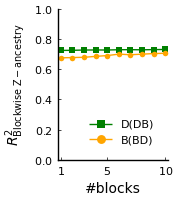

In [131]:
fig = plot(size=(175,200))
plot!(fig,1:10,R2_K_all_DDB,
    ylims=(0,1),
    grid=:off,
    markerstrokewidth=0,
    alpha=1,
    xticks=[1,5,10],
    xlabel="#blocks",
    xguidefontsize=10,
    marker=:square,
    label="D(DB)",
    legend=:bottomright,
    legend_background_color=false,
    ylabel=L"R^2_{\mathrm{Blockwise\;Z-ancestry}}",
    yguidefontsize=10,
    color=:green)
plot!(fig,1:10,R2_K_all_BBD,
    marker=:circle,
    alpha=1,
    markerstrokewidth=0,
    label="B(BD)",
    color=:orange)

In [132]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_pupalWeight"


savefig(fig,"$(dir_output)/blockwise_ancestry.R2.png")
savefig(fig,"$(dir_output)/blockwise_ancestry.R2.pdf")

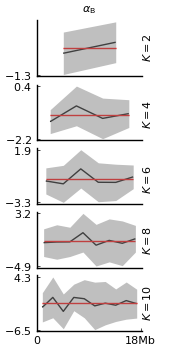

In [128]:
fig = plot(layout=(5,1),size=(175,350))

i=1

for K in 2:2:10
    
    α=α_dict["$(K)"]
    c_int=c_int_dict["$(K)"]
    intervals_midpos=intervals_midpos_dict["$(K)"]

    plot!(fig,intervals_midpos,α,
        title= K==2 ? L"\alpha_{\mathrm{B}}" : "",
        titlefontsize=8,
        grid=:off,
        xlims=(0,chr_size[30]),
        xticks= K==10 ? ([0,18],["0","18Mb"]) : [],
        linecolor=:black,
        right_margin=0.5cm,
        subplot=i,
        label="")
    plot!(fig,intervals_midpos,[α_Z],linecolor=:red,label="",
        subplot=i,)
    plot!(fig,intervals_midpos,c_int[:,1],fillrange=c_int[:,2],
        linewidth=0,
        fillcolor=:gray,
        fillalpha=0.5,
        subplot=i,
        # ylims=(minimum(c_int[:,1]),maximum(c_int[:,2])),
        yticks=[round(minimum(c_int[:,1]),digits=1),round(maximum(c_int[:,2]),digits=1)],
        label="",)
    annotate!(fig,[(chr_size[30]+2,-1,Plots.text(string(L"K=","$(K)"),8,:right,rotation=90))],subplot=i)
    i=i+1
end

fig

In [129]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results/MaternalD/run.pheno_pupalWeight"


savefig(fig,"$(dir_output)/interval_effects.png")
savefig(fig,"$(dir_output)/interval_effects.pdf")

# 5. Plotting pupal weight variation

In [2]:
using KernelDensity
using StatsPlots
using HypothesisTests

In [3]:
ste(u)=std(u)/sqrt(length(u))

ste (generic function with 1 method)

In [ ]:
dir_source = "/n/home00/txiong/Research/2022_HybridSterility/Phenotypes"

dfBBD = DataFrame(CSV.File("$(dir_source)/pupal_weight_BBD.txt",header=false))
dfDDB = DataFrame(CSV.File("$(dir_source)/pupal_weight_DDB.txt",header=false))
dfBD = DataFrame(CSV.File("$(dir_source)/pupal_weight_BD.txt",header=false))
dfB = DataFrame(CSV.File("$(dir_source)/pupal_weight_B.txt",header=false))
dfD = DataFrame(CSV.File("$(dir_source)/pupal_weight_D.txt",header=false))

In [5]:
w_fDB=[0.9015,0.7674,0.6022,0.5576]
w_mDB=[1.3201,1.2691,1.1951,1.0251];

In [6]:
w_fBBD = dfBBD[!,4][dfBBD[!,1] .== "F"]
w_mBBD = dfBBD[!,4][dfBBD[!,1] .== "M"]
w_fDDB = dfDDB[!,5][dfDDB[!,2] .== "F"]
w_mDDB = dfDDB[!,5][dfDDB[!,2] .== "M"]
w_fBD = dfBD[.!ismissing.(dfBD[!,2]),5][dfBD[.!ismissing.(dfBD[!,2]),2] .== "F"]
w_mBD = dfBD[.!ismissing.(dfBD[!,2]),5][dfBD[.!ismissing.(dfBD[!,2]),2] .== "M"]
w_fB = dfB[!,2][dfB[!,1] .== "F"]
w_mB = dfB[!,2][dfB[!,1] .== "M"];
w_fD = dfD[!,2][dfD[!,1] .== "F"]
w_mD = dfD[!,2][dfD[!,1] .== "M"];

w_fBBD = w_fBBD[.!ismissing.(w_fBBD)]
w_mBBD = w_mBBD[.!ismissing.(w_mBBD)]
w_fDDB = w_fDDB[.!ismissing.(w_fDDB)]
w_mDDB = w_mDDB[.!ismissing.(w_mDDB)]
w_fBD = w_fBD[.!ismissing.(w_fBD)]
w_mBD = w_mBD[.!ismissing.(w_mBD)]
w_fB = w_fB[.!ismissing.(w_fB)]
w_mB = w_mB[.!ismissing.(w_mB)]
w_fD = w_fD[.!ismissing.(w_fD)]
w_mD = w_mD[.!ismissing.(w_mD)]

7-element Vector{Float64}:
 1.598
 1.648
 1.721
 1.622
 1.706
 1.604
 1.799

In [7]:
# BBD: nongenetic_proportion = 0.6753230868257278
# DDB: nongenetic_proportion = 0.7247579087214295

function get_geneticVarRatio(Wf,Wm,nongenetic_proportion)

    var_env = var(Wf)*(1-nongenetic_proportion)
    var_f = var(Wf)
    var_m = var(Wm)

    return (var_m-var_env)/(var_f-var_env)
    
end

get_geneticVarRatio (generic function with 1 method)

In [95]:
# bootstrap

n_boostraps = 100000

outputs = []

Wf = w_fBBD
Wm = w_mBBD
nongenetic_proportion = 0.6753230868257278

for i in 1:n_boostraps
    
    
    Wf_1 = Wf[Int.(ceil.(rand(size(Wf)[1])*length(Wf)))]
    Wm_1 = Wm[Int.(ceil.(rand(size(Wm)[1])*length(Wm)))]
    push!(outputs,get_geneticVarRatio(Wf_1,Wm_1,nongenetic_proportion))
    
end

println("Statistics: ")
println(get_geneticVarRatio(Wf,Wm,nongenetic_proportion))
println("95% CI: ")
println(quantile(float.(outputs),0.025))
println(quantile(float.(outputs),0.975))

Statistics: 
0.2254992191740431
95% CI: 
0.05067204960175191
0.4587861021527622


In [6]:
pfBBD = kde(w_fBBD)
pmBBD = kde(w_mBBD)
pfDDB = kde(w_fDDB)
pmDDB = kde(w_mDDB)
pfBD = kde(float.(w_fBD))
pmBD = kde(float.(w_mBD))
pfDB = kde(float.(w_fDB))
pmDB = kde(float.(w_mDB))
pfB = kde(float.(w_fB))
pmB = kde(float.(w_mB));

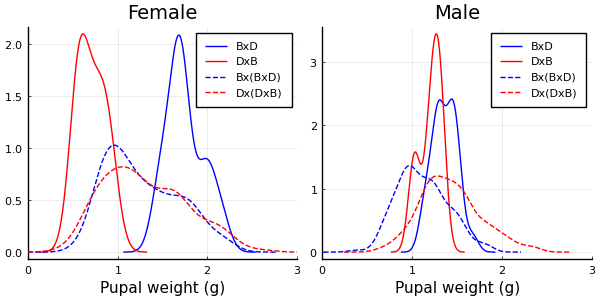

In [17]:
fig = plot(size=(600,300),layout=(1,2))
plot!(fig,pfBD.x,pfBD.density,label="BxD",linecolor=:blue,subplot=1,xlims=(0,3),
    title="Female",xlabel="Pupal weight (g)")
plot!(fig,pmBD.x,pmBD.density,label="BxD",linecolor=:blue,subplot=2,xlims=(0,3),
    title="Male",xlabel="Pupal weight (g)")

plot!(fig,pfDB.x,pfDB.density,label="DxB",linecolor=:red,subplot=1)
plot!(fig,pmDB.x,pmDB.density,label="DxB",linecolor=:red,subplot=2)

plot!(fig,pfBBD.x,pfBBD.density,label="Bx(BxD)",linecolor=:blue,linestyle=:dash,subplot=1)
plot!(fig,pmBBD.x,pmBBD.density,label="Bx(BxD)",linecolor=:blue,linestyle=:dash,subplot=2)

plot!(fig,pfDDB.x,pfDDB.density,label="Dx(DxB)",linecolor=:red,linestyle=:dash,subplot=1)
plot!(fig,pmDDB.x,pmDDB.density,label="Dx(DxB)",linecolor=:red,linestyle=:dash,subplot=2)

In [51]:
UnequalVarianceTTest(w_fB,float.(w_fBD))


Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -0.265357
    95% confidence interval: (-0.4452, -0.08549)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0071

Details:
    number of observations:   [6,14]
    t-statistic:              -3.1865577445527467
    degrees of freedom:       13.02822011354267
    empirical standard error: 0.08327391628498079


In [52]:
UnequalVarianceTTest(w_fB,float.(w_fDB))


Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          0.777825
    95% confidence interval: (0.5357, 1.02)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0002

Details:
    number of observations:   [6,4]
    t-statistic:              7.7485496652605965
    degrees of freedom:       6.38551074600993
    empirical standard error: 0.10038330185676633


In [53]:
UnequalVarianceTTest(w_mB,float.(w_mBD))


Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          6.85714e-5
    95% confidence interval: (-0.1136, 0.1138)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.9990

Details:
    number of observations:   [7,25]
    t-statistic:              0.0013261550083598684
    degrees of freedom:       11.096002315730685
    empirical standard error: 0.05170694838766474


In [54]:
UnequalVarianceTTest(w_mB,float.(w_mDB))


Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          0.159079
    95% confidence interval: (-0.03322, 0.3514)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0889

Details:
    number of observations:   [7,4]
    t-statistic:              2.0401662397176277
    degrees of freedom:       5.812104711589255
    empirical standard error: 0.07797333782495545


In [8]:
UnequalVarianceTTest(w_fD,float.(w_fBD))

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          0.241865
    95% confidence interval: (0.1119, 0.3718)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0010

Details:
    number of observations:   [9,14]
    t-statistic:              3.9059017159709613
    degrees of freedom:       18.296148945702605
    empirical standard error: 0.06192298141453747


In [9]:
UnequalVarianceTTest(w_fD,float.(w_fDB))

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          1.28505
    95% confidence interval: (1.047, 1.523)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0002

Details:
    number of observations:   [9,4]
    t-statistic:              15.384858608837513
    degrees of freedom:       3.7400271213926963
    empirical standard error: 0.08352674892208979


In [10]:
UnequalVarianceTTest(w_mD,float.(w_mBD))

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          0.309783
    95% confidence interval: (0.2279, 0.3916)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-06

Details:
    number of observations:   [7,25]
    t-statistic:              7.931939732020216
    degrees of freedom:       18.612038244693828
    empirical standard error: 0.039055119883513935


In [11]:
UnequalVarianceTTest(w_mD,float.(w_mDB))

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          0.468793
    95% confidence interval: (0.2768, 0.6608)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0023

Details:
    number of observations:   [7,4]
    t-statistic:              6.675593963098664
    degrees of freedom:       4.163890389903538
    empirical standard error: 0.07022489080885529


In [15]:
UnequalVarianceTTest(float.(w_fBBD),float.(w_mBBD))


Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          0.158859
    95% confidence interval: (0.07601, 0.2417)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0002

Details:
    number of observations:   [131,154]
    t-statistic:              3.7782772880255306
    degrees of freedom:       225.36717683303627
    empirical standard error: 0.04204532003697253


In [16]:
UnequalVarianceTTest(float.(w_fDDB),float.(w_mDDB))


Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -0.116464
    95% confidence interval: (-0.2047, -0.02821)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0099

Details:
    number of observations:   [158,168]
    t-statistic:              -2.597455451801717
    degrees of freedom:       287.51924889080834
    empirical standard error: 0.04483783759736875


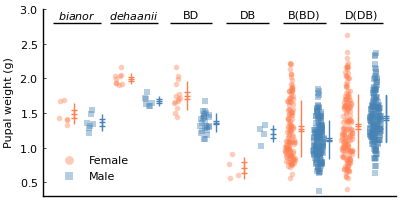

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in 

In [113]:
fig = plot(size=(400,200),
    ylabel="Pupal weight (g)",
    ylims=(0.3,3),
    yguidefontsize=8,
    xticks=[],
    grid=:off,)

X=Array(-3:8).*2

x = 0.75

c1=:steelblue
c2=:coral
msize=5

mtype2=:square


dotplot!(fig,[X[1]],w_fB,alpha=0.4,markerstrokewidth=0,side=:both,
    color=c2,
    legend=:bottomleft,
    legend_background_color=false,
    label="Female")
plot!(fig,repeat([X[1]],3).+x,[mean(w_fB)-ste(w_fB),mean(w_fB),mean(w_fB)+ste(w_fB)],
    marker=:hline,markerstrokewidth=1,markercolor=c2,markersize=msize,
    label="",linecolor=c2,linewidth=1)
plot!(fig,repeat([X[1]],2).+x,[mean(w_fB)-std(w_fB),mean(w_fB)+std(w_fB)],
    marker=:none,markerstrokewidth=1,markercolor=c2,markersize=msize,
    label="",linecolor=c2,linewidth=1)

dotplot!(fig,[X[2]],w_mB,alpha=0.4,markerstrokewidth=0,side=:both,
    color=c1,
    marker=mtype2,
    label="Male")
plot!(fig,repeat([X[2]],3).+x,[mean(w_mB)-ste(w_mB),mean(w_mB),mean(w_mB)+ste(w_mB)],
    marker=:hline,markerstrokewidth=1,markercolor=c1,markersize=msize,
    label="",linecolor=c1,linewidth=1)
plot!(fig,repeat([X[2]],2).+x,[mean(w_mB)-std(w_mB),mean(w_mB)+std(w_mB)],
    marker=:none,markerstrokewidth=1,markercolor=c1,markersize=msize,
    label="",linecolor=c1,linewidth=1)

dotplot!(fig,[X[3]],w_fD,alpha=0.4,markerstrokewidth=0,side=:both,
    color=c2,
    legend=:bottomleft,
    legend_background_color=false,
    label="")
plot!(fig,repeat([X[3]],3).+x,[mean(w_fD)-ste(w_fD),mean(w_fD),mean(w_fD)+ste(w_fD)],
    marker=:hline,markerstrokewidth=1,markercolor=c2,markersize=msize,
    label="",linecolor=c2,linewidth=1)
plot!(fig,repeat([X[3]],2).+x,[mean(w_fD)-std(w_fD),mean(w_fD)+std(w_fD)],
    marker=:none,markerstrokewidth=1,markercolor=c2,markersize=msize,
    label="",linecolor=c2,linewidth=1)

dotplot!(fig,[X[4]],w_mD,alpha=0.4,markerstrokewidth=0,side=:both,
    color=c1,
    marker=mtype2,
    label="")
plot!(fig,repeat([X[4]],3).+x,[mean(w_mD)-ste(w_mD),mean(w_mD),mean(w_mD)+ste(w_mD)],
    marker=:hline,markerstrokewidth=1,markercolor=c1,markersize=msize,
    label="",linecolor=c1,linewidth=1)
plot!(fig,repeat([X[4]],2).+x,[mean(w_mD)-std(w_mD),mean(w_mD)+std(w_mD)],
    marker=:none,markerstrokewidth=1,markercolor=c1,markersize=msize,
    label="",linecolor=c1,linewidth=1)


dotplot!(fig,[X[5]],w_fBD,alpha=0.4,markerstrokewidth=0,side=:both,
    color=c2,
    legend=:bottomleft,
    legend_background_color=false,
    label="")
plot!(fig,repeat([X[5]],3).+x,[mean(w_fBD)-ste(w_fBD),mean(w_fBD),mean(w_fBD)+ste(w_fBD)],
    marker=:hline,markerstrokewidth=1,markercolor=c2,markersize=msize,
    label="",linecolor=c2,linewidth=1)
plot!(fig,repeat([X[5]],2).+x,[mean(w_fBD)-std(w_fBD),mean(w_fBD)+std(w_fBD)],
    marker=:none,markerstrokewidth=1,markercolor=c2,markersize=msize,
    label="",linecolor=c2,linewidth=1)

dotplot!(fig,[X[6]],w_mBD,alpha=0.4,markerstrokewidth=0,side=:both,
    color=c1,
    marker=mtype2,
    label="")
plot!(fig,repeat([X[6]],3).+x,[mean(w_mBD)-ste(w_mBD),mean(w_mBD),mean(w_mBD)+ste(w_mBD)],
    marker=:hline,markerstrokewidth=1,markercolor=c1,markersize=msize,
    label="",linecolor=c1,linewidth=1)
plot!(fig,repeat([X[6]],2).+x,[mean(w_mBD)-std(w_mBD),mean(w_mBD)+std(w_mBD)],
    marker=:none,markerstrokewidth=1,markercolor=c1,markersize=msize,
    label="",linecolor=c1,linewidth=1)

dotplot!(fig,[X[7]],w_fDB,alpha=0.4,markerstrokewidth=0,side=:both,
    color=c2,
    label="")
plot!(fig,repeat([X[7]],3).+x,[mean(w_fDB)-ste(w_fDB),mean(w_fDB),mean(w_fDB)+ste(w_fDB)],
    marker=:hline,markerstrokewidth=1,markercolor=c2,markersize=msize,
    label="",linecolor=c2,linewidth=1)
plot!(fig,repeat([X[7]],2).+x,[mean(w_fDB)-std(w_fDB),mean(w_fDB)+std(w_fDB)],
    marker=:none,markerstrokewidth=1,markercolor=c2,markersize=msize,
    label="",linecolor=c2,linewidth=1)

dotplot!(fig,[X[8]],w_mDB,alpha=0.4,markerstrokewidth=0,side=:both,
    color=c1,
    marker=mtype2,
    label="")
plot!(fig,repeat([X[8]],3).+x,[mean(w_mDB)-ste(w_mDB),mean(w_mDB),mean(w_mDB)+ste(w_mDB)],
    marker=:hline,markerstrokewidth=1,markercolor=c1,markersize=msize,
    label="",linecolor=c1,linewidth=1)
plot!(fig,repeat([X[8]],2).+x,[mean(w_mDB)-std(w_mDB),mean(w_mDB)+std(w_mDB)],
    marker=:none,markerstrokewidth=1,markercolor=c1,markersize=msize,
    label="",linecolor=c1,linewidth=1)


dotplot!(fig,[X[9]],w_fBBD,alpha=0.4,markerstrokewidth=0,side=:both,
    color=c2,
    label="")
plot!(fig,repeat([X[9]],3).+x,[mean(w_fBBD)-ste(w_fBBD),mean(w_fBBD),mean(w_fBBD)+ste(w_fBBD)],
    marker=:hline,markerstrokewidth=1,markercolor=c2,markersize=msize,
    label="",linecolor=c2,linewidth=1)
plot!(fig,repeat([X[9]],2).+x,[mean(w_fBBD)-std(w_fBBD),mean(w_fBBD)+std(w_fBBD)],
    marker=:none,markerstrokewidth=1,markercolor=c2,markersize=msize,
    label="",linecolor=c2,linewidth=1)

dotplot!(fig,[X[10]],w_mBBD,alpha=0.4,markerstrokewidth=0,side=:both,
    color=c1,
    marker=mtype2,
    label="")
plot!(fig,repeat([X[10]],3).+x,[mean(w_mBBD)-ste(w_mBBD),mean(w_mBBD),mean(w_mBBD)+ste(w_mBBD)],
    marker=:hline,markerstrokewidth=1,markercolor=c1,markersize=msize,
    label="",linecolor=c1,linewidth=1)
plot!(fig,repeat([X[10]],2).+x,[mean(w_mBBD)-std(w_mBBD),mean(w_mBBD)+std(w_mBBD)],
    marker=:none,markerstrokewidth=1,markercolor=c1,markersize=msize,
    label="",linecolor=c1,linewidth=1)


dotplot!(fig,[X[11]],w_fDDB,alpha=0.4,markerstrokewidth=0,side=:both,
    color=c2,
    label="")
plot!(fig,repeat([X[11]],3).+x,[mean(w_fDDB)-ste(w_fDDB),mean(w_fDDB),mean(w_fDDB)+ste(w_fDDB)],
    marker=:hline,markerstrokewidth=1,markercolor=c2,markersize=msize,
    label="",linecolor=c2,linewidth=1)
plot!(fig,repeat([X[11]],2).+x,[mean(w_fDDB)-std(w_fDDB),mean(w_fDDB)+std(w_fDDB)],
    marker=:none,markerstrokewidth=1,markercolor=c2,markersize=msize,
    label="",linecolor=c2,linewidth=1)


dotplot!(fig,[X[12]],w_mDDB,alpha=0.4,markerstrokewidth=0,side=:both,
    color=c1,
    marker=mtype2,
    label="")
plot!(fig,repeat([X[12]],3).+x,[mean(w_mDDB)-ste(w_mDDB),mean(w_mDDB),mean(w_mDDB)+ste(w_mDDB)],
    marker=:hline,markerstrokewidth=1,markercolor=c1,markersize=msize,
    label="",linecolor=c1,linewidth=1)
plot!(fig,repeat([X[12]],3).+x,[mean(w_mDDB)-std(w_mDDB),mean(w_mDDB)+std(w_mDDB)],
    marker=:none,markerstrokewidth=1,markercolor=c1,markersize=msize,
    label="",linecolor=c1,linewidth=1)

ann_x = [(X[i]+X[i+1])/2 for i in 1:2:11]
ann_y = [2.9,2.9,2.9,2.9,2.9,2.9]

annotate!(fig,[(ann_x[1],ann_y[1],Plots.text(L"bianor",8)),
                (ann_x[2],ann_y[2],Plots.text(L"dehaanii",8)),
                (ann_x[3],ann_y[3],Plots.text("BD",8)),
                (ann_x[4],ann_y[4],Plots.text("DB",8)),
                (ann_x[5],ann_y[5],Plots.text("B(BD)",8)),
                (ann_x[6],ann_y[6],Plots.text("D(DB)",8))])

plot!(fig,[X[1]-0.7,X[2]+0.7],[ann_y[1],ann_y[1]].-0.1,label="",color=:black,)
plot!(fig,[X[3]-0.7,X[4]+0.7],[ann_y[2],ann_y[2]].-0.1,label="",color=:black,)
plot!(fig,[X[1+4]-0.5,X[2+4]+0.5],[ann_y[1+2],ann_y[1+2]].-0.1,label="",color=:black,)
plot!(fig,[X[3+4]-0.5,X[4+4]+0.5],[ann_y[2+2],ann_y[2+2]].-0.1,label="",color=:black,)
plot!(fig,[X[5+4]-0.5,X[6+4]+0.5],[ann_y[3+2],ann_y[3+2]].-0.1,label="",color=:black,)
plot!(fig,[X[7+4]-0.5,X[8+4]+0.5],[ann_y[4+2],ann_y[4+2]].-0.1,label="",color=:black,)


## test for differences between pure lines and F1

# # females

# y0 = 2.675
# plot!(fig,[X[1],X[5]],[y0,y0],label="",
#     linecolor=c2,
#     marker=:vline,
#     markercolor=c2,
#     annotations=[(X[1]+0.5,y0+0.05,Plots.text(L"**",8,c2,:left))],#p=0.0071 
# )

# y0 = 2.675 - 0.125*1
# plot!(fig,[X[1],X[7]],[y0,y0],label="",
#     linecolor=c2,
#     marker=:vline,
#     markercolor=c2,
#     annotations=[(X[1]+0.5,y0+0.05,Plots.text(L"**",8,c2,:left))],#p=0.0002 
# )

# # males

# y0 = 1.05
# plot!(fig,[X[2],X[6]],[y0,y0],label="",
#     linecolor=c1,
#     marker=:vline,
#     markercolor=c1,
#     annotations=[(X[2]+0.5,y0+0.05,Plots.text("n.s.",8,c1,:left))],#p=0.999   
# )

# y0 = 1.05 - 0.125*1
# plot!(fig,[X[2],X[8]],[y0,y0],label="",
#     linecolor=c1,
#     marker=:vline,
#     markercolor=c1,
#     annotations=[(X[2]+0.5,y0+0.05,Plots.text("n.s.",8,c1,:left))],#p=0.999   
# )



fig

In [ ]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/Phenotypes/phenotype_figures"

savefig(fig,"$(dir_output)/Pupal_weight.pdf")
savefig(fig,"$(dir_output)/Pupal_weight.png")

In [8]:
ΔwDB_B_f = mean(w_fDB) - mean(w_fB)
ΔwDB_D_f = mean(w_fDB) - mean(w_fD)
ΔwBD_B_f = mean(w_fBD) - mean(w_fB)
ΔwBD_D_f = mean(w_fBD) - mean(w_fD)
ΔwDB_B_m = mean(w_mDB) - mean(w_mB)
ΔwDB_D_m = mean(w_mDB) - mean(w_mD)
ΔwBD_B_m = mean(w_mBD) - mean(w_mB)
ΔwBD_D_m = mean(w_mBD) - mean(w_mD)

-0.30978285714285736

In [15]:
ste_ΔwDB_B_f = sqrt(ste(w_fDB)^2 + ste(w_fB)^2)
ste_ΔwDB_D_f = sqrt(ste(w_fDB)^2 + ste(w_fD)^2)
ste_ΔwBD_B_f = sqrt(ste(w_fBD)^2 + ste(w_fB)^2)
ste_ΔwBD_D_f = sqrt(ste(w_fBD)^2 + ste(w_fD)^2)
ste_ΔwDB_B_m = sqrt(ste(w_mDB)^2 + ste(w_mB)^2)
ste_ΔwDB_D_m = sqrt(ste(w_mDB)^2 + ste(w_mD)^2)
ste_ΔwBD_B_m = sqrt(ste(w_mBD)^2 + ste(w_mB)^2)
ste_ΔwBD_D_m = sqrt(ste(w_mBD)^2 + ste(w_mD)^2)

0.039055119883513935

In [90]:
using Printf

In [95]:
ste_ΔwDB_B_fVSm = sqrt(ste(w_fDB)^2 + ste(w_fB)^2+ste(w_mDB)^2 + ste(w_mB)^2)
ste_ΔwBD_B_fVSm = sqrt(ste(w_fBD)^2 + ste(w_fB)^2+ste(w_mBD)^2 + ste(w_mB)^2)
ste_ΔwDB_D_fVSm = sqrt(ste(w_fDB)^2 + ste(w_fD)^2+ste(w_mDB)^2 + ste(w_mD)^2)
ste_ΔwBD_D_fVSm = sqrt(ste(w_fBD)^2 + ste(w_fD)^2+ste(w_mBD)^2 + ste(w_mD)^2)
μ_ΔwDB_B_fVSm = ΔwDB_B_f - ΔwDB_B_m
μ_ΔwBD_B_fVSm = ΔwBD_B_f - ΔwBD_B_m
μ_ΔwDB_D_fVSm = ΔwDB_D_f - ΔwDB_D_m
μ_ΔwBD_D_fVSm = ΔwBD_D_f - ΔwBD_D_m

Z_ΔwDB_B = @sprintf("%.2E", 1-cdf(Normal(),abs(μ_ΔwDB_B_fVSm/ste_ΔwDB_B_fVSm)))
Z_ΔwBD_B = @sprintf("%.2E", 1-cdf(Normal(),abs(μ_ΔwBD_B_fVSm/ste_ΔwBD_B_fVSm)))
Z_ΔwDB_D = @sprintf("%.2E", 1-cdf(Normal(),abs(μ_ΔwDB_D_fVSm/ste_ΔwDB_D_fVSm)))
Z_ΔwBD_D = @sprintf("%.2E", 1-cdf(Normal(),abs(μ_ΔwBD_D_fVSm/ste_ΔwBD_D_fVSm)))


"1.77E-01"

In [105]:
Z_ΔwDB_D

"3.72E-14"

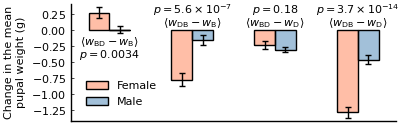

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in 

In [127]:
fig = plot(size=(400,125))

x = 1:4

Δw_f = [ΔwBD_B_f,ΔwDB_B_f,ΔwBD_D_f,ΔwDB_D_f]
Δw_m = [ΔwBD_B_m,ΔwDB_B_m,ΔwBD_D_m,ΔwDB_D_m]
ste_Δw_f = [ste_ΔwBD_B_f,ste_ΔwDB_B_f,ste_ΔwBD_D_f,ste_ΔwDB_D_f]
ste_Δw_m = [ste_ΔwBD_B_m,ste_ΔwDB_B_m,ste_ΔwBD_D_m,ste_ΔwDB_D_m]

bar!(fig,x,Δw_f,bar_width=0.25,
    fillcolor=:coral,
    fillalpha=0.5,
    grid=:off,
    xticks=[],
    ylabel="Change in the mean\npupal weight (g)",
    yguidefontsize=8,
    legend_background_color=false,
    legend=:bottomleft,
    label="Female")
bar!(fig,x.+0.25,Δw_m,bar_width=0.25,
    fillcolor=:steelblue,
    fillalpha=0.5,
    label="Male")

for i in 1:4
    plot!(fig,[x[i],x[i]],[(Δw_f .+ ste_Δw_f)[i],(Δw_f .- ste_Δw_f)[i]],label="",
        color=:black,
        marker=:hline)
    plot!(fig,[x[i],x[i]].+0.25,[(Δw_m .+ ste_Δw_m)[i],(Δw_m .- ste_Δw_m)[i]],label="",
        color=:black,
        marker=:hline)
end

annotate!(fig,[(1+0.125,-0.2,Plots.text(L"\langle w_{\mathsf{BD}}-w_{\mathsf{B}}\rangle",rotation=0,8)),
        (2+0.125,0.1,Plots.text(L"\langle w_{\mathsf{DB}}-w_{\mathsf{B}}\rangle",rotation=0,8)),
        (3+0.125,0.1,Plots.text(L"\langle w_{\mathsf{BD}}-w_{\mathsf{D}}\rangle",rotation=0,8)),
        (4+0.125,0.1,Plots.text(L"\langle w_{\mathsf{DB}}-w_{\mathsf{D}}\rangle",rotation=0,8))
        ])

annotate!(fig,[(1+0.125,-0.4,Plots.text(string(L"p=","0.0034"),rotation=0,8)),
        (2+0.125,0.3,Plots.text(string(L"p=",L"5.6\times10^{-7}"),rotation=0,8)),
        (3+0.125,0.3,Plots.text(string(L"p=","0.18"),rotation=0,8)),
        (4+0.125,0.3,Plots.text(string(L"p=",L"3.7\times10^{-14}"),rotation=0,8))
        ])

fig

In [ ]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/Phenotypes/phenotype_figures"

savefig(fig,"$(dir_output)/Pupal_weight_change_in_the_mean.pdf")
savefig(fig,"$(dir_output)/Pupal_weight_change_in_the_mean.png")

# 6. *Heliconius* data revisited

In [71]:
df = DataFrame(CSV.File("/n/home00/txiong/Research/2022_HybridSterility/Heliconius_Data/dat.4.qtl.lumped.csv"));



In [72]:
chrs = df[13:end,2]
chrs = parse.(Int64,vcat(chrs[chrs.!="x"],repeat(["21"],sum(chrs.=="x"))))

coord = df[13:end,1]
x = getindex.(split.(coord,"_"),2)
coord = parse.(Int64,x)

ind = (.! ismissing.(Array(df[11,:]) .== "male")) .& ((Array(df[11,:]) .== "male").== true)

genotype = Array(df[13:end,:])[:,ind]
phenotype_score = Array(df[8,:])[ind];
phenotype_stage = Array(df[9,:])[ind];

In [73]:
g = transpose(Array(genotype .!= "AA") .* 1/2 .+ Array(genotype .== "AA") .* 0);

In [74]:
g_all = Dict()
l_all = Dict()
for chr in 1:21
    g_all["$(chr)"] = g[:,chrs .== chr]
    l_all["$(chr)"] = coord[chrs .== chr]
end

# remove the last marker from chr19 as it is from a separate scaffold

l_all["19"] = l_all["19"][1:end-1]
g_all["19"] = g_all["19"][:,1:end-1];

# then, drop the last marker to be the chromosome end on each chromosome
# and delete the last marker on genotypes and coordinates

chr_size = [l_all["$i"][end] for i in 1:21]

for chr in 1:21
    g_all["$(chr)"] = g_all["$(chr)"][:,1:end-1]
    l_all["$(chr)"] = l_all["$(chr)"][1:end-1]
end

In [75]:
function get_ancestry_chrs(chr_list,g_all,l_all,chr_size)
    chr = chr_list[1]
    cumulative_anc = zeros(size(g_all["$(chr)"])[1])
    L = 0
    for chr in chr_list
        δl = vcat(l_all["$(chr)"][2:end],[chr_size[chr]]) .- l_all["$(chr)"]
        cumulative_anc = cumulative_anc .+ g_all["$(chr)"] * (δl)
        L = L + sum(δl)
    end
    return cumulative_anc ./ L
end

get_ancestry_chrs (generic function with 1 method)

In [76]:
anc_A = get_ancestry_chrs(1:20,g_all,l_all,chr_size)
anc_Z = get_ancestry_chrs([21],g_all,l_all,chr_size) .* 2;

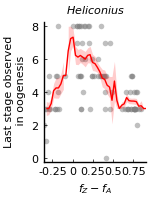

In [77]:
# p = parse.(Float64,phenotype_score) # scored between 0 and 3
p = parse.(Float64,phenotype_stage) # scored between 0 and 8

f(x, q) = q[1] .* x .^ 2 + q[2] .* x .+ q[3]

xdata = anc_Z .- anc_A
ydata = p
q0=[0,0,0.5]

fit = curve_fit(f, xdata, ydata, q0)

wid = 0.15
x_l = -0.4:wid/5:0.85
x_r = x_l .+ wid

x_mid = (x_r.+x_l)/2
ymean = [mean(ydata[(xdata .<= x_r[i]) .& (xdata .> x_l[i])]) for i in 1:size(x_l)[1]]
yste = begin
    
    σ = [std(ydata[(xdata .<= x_r[i]) .& (xdata .> x_l[i])]) for i in 1:size(x_l)[1]]
    n = [length(ydata[(xdata .<= x_r[i]) .& (xdata .> x_l[i])]) for i in 1:size(x_l)[1]]
    σ ./ sqrt.(n)
end

x_mid = x_mid[.!isnan.(ymean)]
yste = yste[.!isnan.(ymean)]
ymean = ymean[.!isnan.(ymean)]


fig = plot(size=(150,200))
scatter!(fig,anc_Z .- anc_A,p,
    xlabel=L"f_Z-f_A",
    ylabel="Last stage observed\n in oogenesis",
    # ylabel="Numerical ovary\nphenotype score",
    title=L"Heliconius",
    titlefontsize=8,
    xticks=([-0.25,0,0.25,0.5,0.75],["-0.25","0","0.25","0.5","0.75"]),
    xlims=(-Inf,+Inf),
    xguidefontsize=8,
    yguidefontsize=8,
    label="",
    markeralpha=0.5,
    markercolor=:gray,
    grid=:off,
    markerstrokewidth=0)

# plot!(-0.35:0.01:0.85,f(-0.35:0.01:0.85,coef(fit)),
#     color=:gray,
#     linestyle=:solid,
#     label="")

plot!((x_r.+x_l)/2,ymean,
    color=:red,
    linestyle=:solid,
    label="")

plot!((x_r.+x_l)/2,ymean.+yste,
    fillrange=ymean.-yste,
    fillcolor=:red,
    fillalpha=0.2,
    linewidth=0,label="")

In [58]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/Heliconius_Data"

prefix = "NumericalPhenotypeScore_DifferenceZA"
# prefix = "LastStageOogenesis_DifferenceZA"


savefig(fig,string(dir_output,"/",prefix,".png"))
savefig(fig,string(dir_output,"/",prefix,".pdf"))

In [ ]:
g_all["21"]

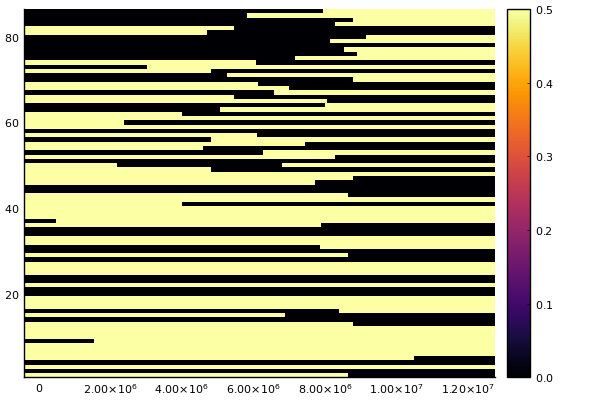

In [15]:
# the following figure has the vertical axis arranged from the best phenotype (top) to the worst (bottom)
# horizontal axis is the physical position on the Z chromosome

p = parse.(Float64,phenotype_stage) # scored between 0 and 8

g_filt = g_all["21"][sortperm(p),:]
heatmap(l_all["21"],1:size(g_filt)[1],g_filt)

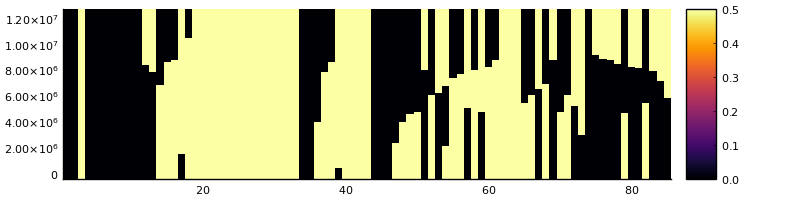

In [80]:
# plot the same data but transposed, and haplotypes are slightly more organized  
# y axis is the Z chromosome physical position
# x axis: left - the worst phenotype; right - the best phenotype

g_filt_2 = zeros(0,size(g_all["21"])[2])

for i in 1:8
    
    idx = p .== i
    
    g_sub = g_all["21"][idx,:]
    
    g_filt_2 = vcat(g_filt_2,g_sub[sortperm(mean(g_sub;dims=2)[:,1]),:])
    
end

fig = plot(size=(800,200))

heatmap!(fig,1:size(g_filt_2)[1],l_all["21"],transpose(g_filt_2))